In [271]:
import cv2
import numpy as np
import pandas as pd
import random
import os
from matplotlib import pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from tqdm import tqdm
import json

from pprint import pprint

import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [272]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [273]:
def cv2_imshow(image, figsize=(10, 8)):
    """
    Display an image with Matplotlib, hardcoding the plot size.
    
    Args:
        image (ndarray): The image to display (BGR or grayscale).
        figsize (tuple): Tuple (width, height) for the plot size in inches.
    """
    # Check if the image is in BGR format and convert to RGB for proper display
    if len(image.shape) == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif len(image.shape) == 2:  # Grayscale image
        plt.gray()  # Set color map to gray for grayscale images

    # Display the image with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis for better display
    plt.show()

In [274]:
def draw_image_and_keypoints(bbox, keypoint, image_path, predicted_point = None, point_size = 1, figsize = (10, 8), optional_text: str = None, handedness=None, orientation=None):
  """
  Uses the normalized input to draw the bounding box and keypoints on the image.
  """
  image = cv2.imread(image_path)
  image_h = image.shape[0]
  image_w = image.shape[1]
  if bbox is not None:
    # Extract the bounding box coordinates
    x_min = int((bbox[0] - bbox[2] / 2) * image_w)
    y_min = int((bbox[1] - bbox[3] / 2) * image_h)
    x_max = int((bbox[0] + bbox[2] / 2) * image_w)
    y_max = int((bbox[1] + bbox[3] / 2) * image_h)

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

  # Draw the keypoints
  index = 0
  for kp in keypoint:
    x_kp = int(kp[0] * image_w)
    y_kp = int(kp[1] * image_h)
    if kp[2] == 0:
      index += 1
      continue
    # Draw the circle
    cv2.circle(image, (x_kp, y_kp), int(point_size), (0, 0, 255), -1)
    # Annotate the keypoint
    cv2.putText(image, str(index), (x_kp, y_kp), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.5), 1), (0, 0, 0), int(point_size*0.66), cv2.LINE_AA)
    index += 1
  
  # If handedness is None, do nothing 
  if handedness is not None:
    # If handedness is 0 then draw "Left" as text on the image at top left
    if handedness == 0:
      cv2.putText(image, "Left", (int(image_w*0.05), int(image_h*0.05)), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 0, 0), int(point_size*0.9), cv2.LINE_AA)
    # If handedness is 1 then draw "Right" as text on the image at top left
    else:
      cv2.putText(image, "Right", (int(image_w*0.05), int(image_h*0.05)), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 0, 0), int(point_size*0.9), cv2.LINE_AA)

  # If orientation is 0, draw "Palmar" if 1 "Dorsal"
  if orientation is not None:
    # draw text top right
    if orientation == 0:
      cv2.putText(image, "Palmar", (int(image_w*0.75), int(image_h*0.05)), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 0, 0), int(point_size*0.9), cv2.LINE_AA)
    else:
      cv2.putText(image, "Dorsal", (int(image_w*0.75), int(image_h*0.05)), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 0, 0), int(point_size*0.9), cv2.LINE_AA)

  if optional_text is not None:
    cv2.putText(image, optional_text, (int(image_w*0.45), int(image_h*0.15)), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 0, 0), int(point_size*0.9), cv2.LINE_AA)

  if predicted_point is not None:
    x_pred = int(predicted_point[0] * image_w)
    y_pred = int(predicted_point[1] * image_h)
    cv2.circle(image, (x_pred, y_pred), int(point_size), (255, 0, 0), -1)
    cv2.putText(image, "P", (x_pred, y_pred), cv2.FONT_HERSHEY_SIMPLEX, max(int(point_size*0.6), 1), (0, 50, 0), int(point_size*0.66), cv2.LINE_AA)
  # Display the image with bounding box and keypoints
  cv2_imshow(image, figsize)



In [275]:
def attempt_to_find_image_path(possible_dirs, file_name, image=True):
  # Strip extension from file_name
  file_name = file_name.split('.')[0]
  # Look for the base name + image extensions
  for directory in possible_dirs:
    for ext in ['jpg', 'jpeg', 'png']:
      if image:
        file_path = f"{directory}/{file_name}.{ext}"
        if os.path.exists(file_path):
          return file_path
  # Throw error if not found
  raise FileNotFoundError(f"File {file_name} not found in any of the directories.")

In [276]:
def attempt_to_draw_from_df(input_df, file_name, possible_image_dirs, keypoints_mask, extra_keypoints_mask = None, figsize = (8, 6), font_scale = None, font_thickness = 2, point_size = 8):
  hands_from_the_file_rows = input_df[input_df['FILE_NAME'] == file_name]


  greens_list = [(i*255/5, 255, i*255/5) for i in range(3)]
  blues_list = [(255, i*255/5, i*255/5) for i in range(3)]
  reds_list = [(i*255/5, i*255/5, 255) for i in range(3)]
  
  # Attempt to find image path
  relative_img_path = attempt_to_find_image_path(possible_image_dirs, file_name)
  hands_from_the_file_rows.reset_index(drop=True, inplace=True)
  
  # Load image
  img = cv2.imread(relative_img_path)
  img_height = img.shape[0]
  img_width = img.shape[1]
  white_thickness = max(2, int(font_thickness*0.75))
  white_point_size_inside = int(point_size*0.5)
  for i, row in hands_from_the_file_rows.iterrows():
    # If there is a bounding box column, draw the bounding box
    if "BB_CX" in hands_from_the_file_rows.columns:
      bb_cx = row["BB_CX"]
      bb_cy = row["BB_CY"]
      bb_w = row["BB_W"]
      bb_h = row["BB_H"]
      if font_scale is None:
        font_scale = max(2, 5*np.sqrt(bb_w*bb_h*img_width*img_height)/(800))
      if font_thickness is None:
        font_thickness = max(2, int(100*np.sqrt(bb_w*bb_h*img_width*img_height)/(3800)))
        white_thickness = max(2, int(font_thickness*0.75))
      if point_size is None:
        point_size = int(90*np.sqrt(bb_w*bb_h*img_width*img_height)/(4000))
        white_point_size_inside = int(point_size*0.5)
      
      x = int((bb_cx - bb_w / 2) * img_width)
      y = int((bb_cy - bb_h / 2) * img_height)
      w = int(bb_w * img_width)
      h = int(bb_h * img_height)
      cv2.rectangle(img, (x, y), (x + w, y + h), greens_list[i], 2)
    
    # Draw keypoints
    for kp_index, kp in enumerate(keypoints_mask):
      x = int(row[f"{kp}_x"] * img_width)
      y = int(row[f"{kp}_y"] * img_height)
      if kp_index ==0:
        # Draw the handedness if it exists
        if "HANDEDNESS" in hands_from_the_file_rows.columns:
          handedness = row["HANDEDNESS"]
          handedness_text = "Right" if handedness == 1 else "Left"
          # Draw text
          cv2.putText(img, handedness_text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, int(font_scale*0.8), (0, 0, 0), font_thickness)
          # Draw white inline
          cv2.putText(img, handedness_text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, int(font_scale*0.8), (255, 255, 255), white_thickness)
      # Draw text of index
      cv2.putText(img, str(kp_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (0, 0, 0), font_thickness//2)
      # Draw white inline
      cv2.putText(img, str(kp_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (255, 255, 255), white_thickness//2)
      cv2.circle(img, (x, y), point_size, reds_list[i], -1)
      cv2.circle(img, (x, y), white_point_size_inside, (255, 255, 255), -1)
    
    if extra_keypoints_mask is not None:
      for kp_index, kp in enumerate(extra_keypoints_mask):
        x = int(row[f"{kp}_x"] * img_width)
        y = int(row[f"{kp}_y"] * img_height)
        cv2.circle(img, (x, y), point_size, blues_list[i], -1)
        cv2.circle(img, (x, y), white_point_size_inside, (255, 255, 255), -1)
        cv2.putText(img, kp, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (0, 0, 0), font_thickness//2)
        cv2.putText(img, kp, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (255, 255, 255), white_thickness//2)

  # Display the image
  plt.figure(figsize=figsize)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()


In [277]:
def is_image_file(file_name):
    valid_extensions = ('.jpg', '.jpeg', '.png')  # Add more formats as needed
    return file_name.lower().endswith(valid_extensions)

def make_hand_keypoint_label_files(path_to_image_dir: str, detector, path_to_output_dir):
    # Get all the image files
    img_files = [file_name for file_name in os.listdir(path_to_image_dir) if is_image_file(file_name)]    

    for file_name in tqdm(img_files, desc="Processing images"):
        # Load the image
        current_img = mp.Image.create_from_file(os.path.join(path_to_image_dir, file_name))
        result = detector.detect(current_img)
        
        # Prepare the data to save
        list_of_hand_dicts = []
        hand_landmarks_list = result.hand_landmarks
        handedness_list = result.handedness

        for idx in range(len(hand_landmarks_list)):
            hand_dict = {}
            normalised_keypoints = hand_landmarks_list[idx]
            hand_dict["handedness"] = 0 if handedness_list[idx][0].category_name == "Left" else 1
            hand_dict["keypoints"] = []
            for landmark in normalised_keypoints:
                # Determine visibility
                true_visibility = 1 if 0 <= landmark.x <= 1 and 0 <= landmark.y <= 1 else 0
                hand_dict["keypoints"].append({"x": landmark.x, "y": landmark.y, "z": landmark.z, "visibility": true_visibility})
            list_of_hand_dicts.append(hand_dict)
        
        # Generate .json file name by replacing the file extension
        base_name, _ = os.path.splitext(file_name)  # Split file name and extension
        json_file_name = base_name + ".json"

        # Write to JSON
        with open(os.path.join(path_to_output_dir, json_file_name), "w") as f:
            json.dump(list_of_hand_dicts, f)
    return


In [278]:
def parse_yolo_compatible_string(data_string):
    # Split the string into individual values
    values = list(map(float, data_string.split()))
    
    # Extract the class ID
    class_id = int(values[0])
    
    # Extract the bounding box parameters
    bbox = values[1:5]
    
    # Extract the keypoints (21 tuples of (norm_x, norm_y, visible))
    keypoints = []
    for i in range(5, len(values), 3):
        keypoints.append((values[i], values[i + 1], int(values[i + 2])))
    
    # Return the parsed data
    return class_id, bbox, keypoints

def load_df_yolo_labels_from_dir(path_to_yolo_labels):
    def create_dataframe_row(file_name, bb_params, keypoints):
        # Prepare the bounding box parameters
        bb_x, bb_y, bb_w, bb_h = bb_params

        # Prepare the list of keypoints
        keypoint_dict = {}
        keypoint_names = [
            "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
            "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
            "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
            "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
            "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
            "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
        ]

        # Add keypoints to the dictionary
        for i, (x, y, visibility) in enumerate(keypoints):
            if visibility == 0:
                keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
                keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
            else:
                keypoint_dict[f"{keypoint_names[i]}_x"] = x
                keypoint_dict[f"{keypoint_names[i]}_y"] = y

        # Construct the dataframe row
        row = {
            "FILE_NAME": file_name,
            "bb_x": bb_x,
            "bb_y": bb_y,
            "bb_w": bb_w,
            "bb_h": bb_h,
            **keypoint_dict
        }
        return row 

    list_of_rows = []

    directory = os.path.join(path_to_yolo_labels)
    # Iterate through each file in the directory
    for filename in tqdm(os.listdir(directory), desc = "Processing Ultralytics YOLO labels"):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            
            # Open and read each .txt file
            with open(file_path, 'r') as file:
                class_id, bbox, keypoints = parse_yolo_compatible_string(file.readline())
                list_of_rows.append(create_dataframe_row(filename, bbox, keypoints))
    return pd.DataFrame(list_of_rows)

In [279]:
# Returns a dataframe with flattened keypoints and additional data
def load_df_mp_hand_keypoints(json_dir: str, extra_point = False): 
    def create_dataframe_row(file_name, keypoints, hand_id, handedness, extra_point_coords = None):    
        # RETURNS A DICTIONARY OF KEYPOINTS
        # Prepare the list of keypoints
        keypoint_dict = {}
        keypoint_names = [
            "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
            "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
            "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
            "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
            "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
            "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
        ]
        
        # Add keypoints to the dictionary
        for i, kp in enumerate(keypoints):
            if kp['visibility'] == 0:
                keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
                keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
            else:
                keypoint_dict[f"{keypoint_names[i]}_x"] = kp['x']
                keypoint_dict[f"{keypoint_names[i]}_y"] = kp['y']
        
        # Add the extra point if it exists
        if extra_point_coords:
            keypoint_dict["HYPOTHENAR_x"] = extra_point_coords["x"]
            keypoint_dict["HYPOTHENAR_y"] = extra_point_coords["y"]

        # Construct the dataframe row
        row = {
            "FILE_NAME": file_name,
            "HAND_ID": hand_id,
            "HANDEDNESS": handedness,
            **keypoint_dict
        }
        return row 

    list_of_rows = []
    for file_name in tqdm(os.listdir(json_dir), desc = "Loading JSON files"):
        with open(os.path.join(json_dir, file_name), "r") as f:
            hands = json.load(f)
            for i in range(len(hands)):
                if extra_point:
                    list_of_rows.append(create_dataframe_row(file_name, hands[i]["keypoints"], hand_id= i, handedness=hands[i]["handedness"], extra_point_coords = hands[i]["extra_point"]))
                else:
                    list_of_rows.append(create_dataframe_row(file_name, hands[i]["keypoints"], hand_id= i, handedness=hands[i]["handedness"]))
    return pd.DataFrame(list_of_rows)


In [280]:
def hagrid_bbox_to_yolo_bbox(bbox):
  """
  Given the bbox in Hagrid format, this function will return the bbox in YOLO format.
  """
  x, y, w, h = bbox

  return [x+w/2, y+h/2, w, h]

def load_hagrid(path_to_json_file):
  """
  Given the path to the json file and the path to the images, this function will return the data in the format:
  {
    "uuid": {
      "bbox": [x, y, w, h],
      "keypoints": [[x, y, v], ...]

  """
  with open(path_to_json_file) as f:
    data = json.load(f)
  
  list_of_rows = []
  for uuid, value in data.items():
    if len(value['hand_landmarks']) != 1:
      continue
    bbox = value['bboxes'][0]
    yolo_bbox = hagrid_bbox_to_yolo_bbox(bbox)
    keypoints = value['hand_landmarks'][0]
    keypoint_dict = {}
    keypoint_names = [
        "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
        "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
        "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
        "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
        "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
        "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
    ]

    # Add keypoints to the dictionary
    for i, (x, y) in enumerate(keypoints):
        # if visibility == 0:
        #   keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
        #   keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
        # else:
      keypoint_dict[f"{keypoint_names[i]}_x"] = x
      keypoint_dict[f"{keypoint_names[i]}_y"] = y

    row = {
        "FILE_NAME": uuid,
        "BB_CX": yolo_bbox[0],
        "BB_CY": yolo_bbox[1],
        "BB_W": yolo_bbox[2],
        "BB_H": yolo_bbox[3],
        **keypoint_dict
    }
    list_of_rows.append(row)
  return pd.DataFrame(list_of_rows)


In [281]:
def get_cummulative_spatial_error(df1, df2, hand_keypoints):
    # Return a series of errors (sums of euclidean distances between keypoints)
    # Calculate the sum of the euclidean distances between the keypoints as a measure of error
    def get_error(row1, row2):
        error = 0
        for kp in hand_keypoints:
            x1 = row1[f"{kp}_x"]
            y1 = row1[f"{kp}_y"]
            x2 = row2[f"{kp}_x"]
            y2 = row2[f"{kp}_y"]
            error += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        return error
    
    errors = []
    for i in range(len(df1)):
        errors.append(get_error(df1.iloc[i], df2.iloc[i]))
    return errors

def get_mean_cummulative_spatial_error(df1, df2, hand_keypoints):
    # Calculate the sum of the euclidean distances between the keypoints as a measure of error
    # Average of cumulative euclidean distances
    def get_error(row1, row2):
        error = 0
        for kp in hand_keypoints:
            x1 = row1[f"{kp}_x"]
            y1 = row1[f"{kp}_y"]
            x2 = row2[f"{kp}_x"]
            y2 = row2[f"{kp}_y"]
            error += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        return error
    
    errors = []
    for i in range(len(df1)):
        errors.append(get_error(df1.iloc[i], df2.iloc[i]))
    return np.mean(errors)

def average_middle_finger(df):
    # Calculate the average distance from MIDDLE_FINGER_MCP to MIDDLE_FINGER_TIP
    errors = []
    for i in range(len(df)):
        x1 = df.iloc[i]["MIDDLE_FINGER_MCP_x"]
        y1 = df.iloc[i]["MIDDLE_FINGER_MCP_y"]
        x2 = df.iloc[i]["MIDDLE_FINGER_TIP_x"]
        y2 = df.iloc[i]["MIDDLE_FINGER_TIP_y"]
        errors.append(np.sqrt((x1 - x2)**2 + (y1 - y2)**2))
    return np.mean(errors)

In [282]:
def generate_df_bounding_boxes(df, keypoints_mask, padding=0.1):
    def get_bounding_box(row, padding):
        # Get the x and y coordinates of the keypoints
        x_coords = [row[f"{kp}_x"] for kp in keypoints_mask]
        y_coords = [row[f"{kp}_y"] for kp in keypoints_mask]

        # Calculate the bounding box parameters
        bb_x = min(x_coords)
        bb_y = min(y_coords)
        bb_w = max(x_coords) - bb_x
        bb_h = max(y_coords) - bb_y

        # Calculate center of the bounding box
        bb_cx = bb_x + bb_w / 2
        bb_cy = bb_y + bb_h / 2

        # Calculate maximum padding to keep the box within image boundaries
        max_padding_x = min(bb_cx - bb_w / 2, 1 - (bb_cx + bb_w / 2)) / (bb_w / 2)
        max_padding_y = min(bb_cy - bb_h / 2, 1 - (bb_cy + bb_h / 2)) / (bb_h / 2)
        max_padding = min(max_padding_x, max_padding_y)

        # Apply the smaller of the user-provided padding or max possible padding
        effective_padding = min(padding, max_padding)
        bb_w *= (1 + effective_padding)
        bb_h *= (1 + effective_padding)

        return bb_cx, bb_cy, bb_w, bb_h

    # Return DataFrame with the columns BB_CX, BB_CY, BB_W, BB_H
    return pd.DataFrame(
        [get_bounding_box(row, padding) for _, row in df.iterrows()],
        columns=["BB_CX", "BB_CY", "BB_W", "BB_H"]
    )

def img_to_bb_space_transform_df(df, keypoints_mask):
    def image_to_bounding_box_space(x_img, y_img, bb_center_x, bb_center_y, bb_width, bb_height):
        # Shift origin to bounding box center
        x_shifted = x_img - bb_center_x
        y_shifted = y_img - bb_center_y

        # Normalize by half the bounding box dimensions
        x_bb = x_shifted / (bb_width / 2)
        y_bb = y_shifted / (bb_height / 2)

        return x_bb, y_bb
    
    def image_to_bounding_box_space_row(row):
        # Get the bounding box parameters
        bb_cx = row["BB_CX"]
        bb_cy = row["BB_CY"]
        bb_w = row["BB_W"]
        bb_h = row["BB_H"]
        
        # Apply the transformation to each keypoint
        for kp in keypoints_mask:
            x_img = row[f"{kp}_x"]
            y_img = row[f"{kp}_y"]
            x_bb, y_bb = image_to_bounding_box_space(x_img, y_img, bb_cx, bb_cy, bb_w, bb_h)
            row[f"{kp}_x"] = x_bb
            row[f"{kp}_y"] = y_bb
        return row
    
    return df.apply(image_to_bounding_box_space_row, axis=1)

def bb_to_img_space_transform_df(df, keypoints_mask):
    def bounding_box_to_image_space(x_bb, y_bb, bb_center_x, bb_center_y, bb_width, bb_height):
        # Denormalize by half the bounding box dimensions
        x_shifted = x_bb * (bb_width / 2)
        y_shifted = y_bb * (bb_height / 2)
        
        # Shift origin back to the image space
        x_img = x_shifted + bb_center_x
        y_img = y_shifted + bb_center_y

        return x_img, y_img
    
    def bounding_box_to_image_space_row(row):
        # Get the bounding box parameters
        bb_cx = row["BB_CX"]
        bb_cy = row["BB_CY"]
        bb_w = row["BB_W"]
        bb_h = row["BB_H"]
        
        # Apply the transformation to each keypoint
        for kp in keypoints_mask:
            x_bb = row[f"{kp}_x"]
            y_bb = row[f"{kp}_y"]
            x_img, y_img = bounding_box_to_image_space(x_bb, y_bb, bb_cx, bb_cy, bb_w, bb_h)
            row[f"{kp}_x"] = x_img
            row[f"{kp}_y"] = y_img
        return row
    
    return df.apply(bounding_box_to_image_space_row, axis=1)

def calculate_rotation_angle_degrees(wrist_x, wrist_y, middle_finger_mcp_x, middle_finger_mcp_y):
    # Form the vector (WRIST -> MIDDLE_FINGER_MCP)
    vector_x = middle_finger_mcp_x - wrist_x
    vector_y = middle_finger_mcp_y - wrist_y

    # Normalize the vector
    magnitude = np.sqrt(vector_x**2 + vector_y**2)
    unit_vector_x = vector_x / magnitude
    unit_vector_y = vector_y / magnitude

    # Calculate the angle to align with (0,1) using dot product
    dot_product = unit_vector_y  # Since (0,1) has x=0
    angle_rad = np.arccos(dot_product)

    # Determine the sign of rotation using the cross product (to account for direction)
    cross_product = unit_vector_x
    if cross_product < 0:
        angle_rad = -angle_rad

    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def rotate_point(x, y, angle_rad):
    # Apply 2D rotation matrix
    rotated_x = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    rotated_y = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return rotated_x, rotated_y

def transform_to_rotated_bb_space(df, keypoints_mask, wrist_key, middle_finger_mcp_key):
    def rotate_bb_space_row(row):
        # Get the rotation angle in degrees
        wrist_x, wrist_y = row[f"{wrist_key}_x"], row[f"{wrist_key}_y"]
        middle_finger_x, middle_finger_y = row[f"{middle_finger_mcp_key}_x"], row[f"{middle_finger_mcp_key}_y"]
        angle_deg = calculate_rotation_angle_degrees(wrist_x, wrist_y, middle_finger_x, middle_finger_y)

        # Convert degrees to radians for rotation
        angle_rad = np.radians(angle_deg)

        # Rotate each keypoint
        for kp in keypoints_mask:
            x_bb = row[f"{kp}_x"]
            y_bb = row[f"{kp}_y"]
            rotated_x, rotated_y = rotate_point(x_bb, y_bb, angle_rad)
            row[f"{kp}_x"] = rotated_x
            row[f"{kp}_y"] = rotated_y

        # Add the rotation degree to the row
        row["ROT_DEG"] = angle_deg
        return row

    return df.apply(rotate_bb_space_row, axis=1)

def reverse_rotation_from_rotated_bb_space(df, keypoints_mask):
    def reverse_rotate_bb_space_row(row):
        # Get the rotation angle in degrees and convert to radians
        angle_deg = row["ROT_DEG"]
        angle_rad = np.radians(-angle_deg)  # Negate the angle for reverse rotation

        # Reverse rotate each keypoint
        for kp in keypoints_mask:
            x_rot = row[f"{kp}_x"]
            y_rot = row[f"{kp}_y"]
            original_x, original_y = rotate_point(x_rot, y_rot, angle_rad)
            row[f"{kp}_x"] = original_x
            row[f"{kp}_y"] = original_y

        return row

    return df.apply(reverse_rotate_bb_space_row, axis=1)

### Data Processing

In [283]:
hand_keypoints_names = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_FINGER_MCP",
    6: "INDEX_FINGER_PIP",
    7: "INDEX_FINGER_DIP",
    8: "INDEX_FINGER_TIP",
    9: "MIDDLE_FINGER_MCP",
    10: "MIDDLE_FINGER_PIP",
    11: "MIDDLE_FINGER_DIP",
    12: "MIDDLE_FINGER_TIP",
    13: "RING_FINGER_MCP",
    14: "RING_FINGER_PIP",
    15: "RING_FINGER_DIP",
    16: "RING_FINGER_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP"
}

flattened_keypoint_names = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() for axis in ["x", "y"]]

In [284]:
# Instantiate MEDIAPIPE DETECTOR MODEL
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')

single_hand_options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
two_hand_options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)

single_hand_detector = vision.HandLandmarker.create_from_options(single_hand_options)
two_hand_detector = vision.HandLandmarker.create_from_options(two_hand_options)


In [285]:
# DEFINE PATHS
path_to_11k_train_labels = 'hand-keypoints/train/labels'
path_to_11k_val_labels = 'hand-keypoints/val/labels'
path_to_11k_train_images = 'hand-keypoints/train/images'
path_to_11k_val_images = 'hand-keypoints/val/images'

path_to_11k_train_generated_labels = 'hand-keypoints/train/mp_labels'
path_to_11k_val_generated_labels = 'hand-keypoints/val/mp_labels'

In [286]:
if not os.listdir(path_to_11k_train_generated_labels): 
    make_hand_keypoint_label_files(path_to_11k_train_images, single_hand_detector, path_to_11k_train_generated_labels)

In [287]:
if not os.listdir(path_to_11k_val_generated_labels): 
    make_hand_keypoint_label_files(path_to_11k_val_images, single_hand_detector, path_to_11k_val_generated_labels)

### Let's check the similarity between the provided labels and generated labels

In [288]:
yolo_11k_train_df = load_df_yolo_labels_from_dir(path_to_11k_train_labels)
yolo_11k_val_df = load_df_yolo_labels_from_dir(path_to_11k_val_labels)

mp_11k_train_df = load_df_mp_hand_keypoints(path_to_11k_train_generated_labels)
mp_11k_val_df = load_df_mp_hand_keypoints(path_to_11k_val_generated_labels)

yolo_11k_total_df = pd.concat([yolo_11k_train_df, yolo_11k_val_df])
mp_11k_total_df = pd.concat([mp_11k_train_df, mp_11k_val_df])

Loading JSON files: 100%|██████████| 3125/3125 [00:00<00:00, 5472.86it/s]


In [289]:
mp_11k_total_df['FILE_BASE_NAME'] = mp_11k_total_df['FILE_NAME'].apply(lambda x: x.split('.')[0])
yolo_11k_total_df['FILE_BASE_NAME'] = yolo_11k_total_df['FILE_NAME'].apply(lambda x: x.split('.')[0])

In [290]:
mp_11k_total_bounding_boxes_df = generate_df_bounding_boxes(mp_11k_total_df, keypoints_mask = hand_keypoints_names.values())
# Add the columns to the dataframe
mp_11k_total_bounding_boxes_df.index = mp_11k_total_df.index
mp_11k_total_df = pd.concat([mp_11k_total_df, mp_11k_total_bounding_boxes_df], axis=1)

In [291]:
yolo_11k_total_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)

In [292]:
# Drop NaNs
mp_11k_total_df = mp_11k_total_df.dropna()
yolo_11k_total_df = yolo_11k_total_df.dropna()
# yolo_11k to only have the same files as mp_11k
yolo_11k_total_df = yolo_11k_total_df[yolo_11k_total_df['FILE_BASE_NAME'].isin(mp_11k_total_df['FILE_BASE_NAME'])]
# mp_11k to only have the same files as yolo_11k
mp_11k_total_df = mp_11k_total_df[mp_11k_total_df['FILE_BASE_NAME'].isin(yolo_11k_total_df['FILE_BASE_NAME'])]

In [293]:
# Sort yolo and mp on FILE_BASE_NAME
yolo_11k_total_df.sort_values(by=['FILE_BASE_NAME'], inplace=True)
mp_11k_total_df.sort_values(by=['FILE_BASE_NAME'], inplace=True)

In [294]:
print("Yolo length is:", len(yolo_11k_total_df), "MP length is:", len(mp_11k_total_df))
assert(len(yolo_11k_total_df) == len(mp_11k_total_df))

Yolo length is: 5910 MP length is: 5910


In [295]:
def calculate_mean_iou(df_detected, df_ground_truth):
    """
    Calculate the mean IoU (%) between detected and ground truth bounding boxes.

    Parameters:
        df_detected (pd.DataFrame): DataFrame with detected bounding boxes (BB_CX, BB_CY, BB_H, BB_W).
        df_ground_truth (pd.DataFrame): DataFrame with ground truth bounding boxes (BB_CX, BB_CY, BB_H, BB_W).

    Returns:
        float: Mean IoU in percentage.
    """
    def calculate_iou(row1, row2):
        # Extract coordinates and sizes
        x1_det, y1_det = row1['BB_CX'] - row1['BB_W'] / 2, row1['BB_CY'] - row1['BB_H'] / 2
        x2_det, y2_det = row1['BB_CX'] + row1['BB_W'] / 2, row1['BB_CY'] + row1['BB_H'] / 2
        
        x1_gt, y1_gt = row2['BB_CX'] - row2['BB_W'] / 2, row2['BB_CY'] - row2['BB_H'] / 2
        x2_gt, y2_gt = row2['BB_CX'] + row2['BB_W'] / 2, row2['BB_CY'] + row2['BB_H'] / 2
        
        # Calculate intersection coordinates
        x_left = max(x1_det, x1_gt)
        y_top = max(y1_det, y1_gt)
        x_right = min(x2_det, x2_gt)
        y_bottom = min(y2_det, y2_gt)
        
        # Check for non-overlapping boxes
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        # Calculate intersection and union areas
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        det_area = row1['BB_W'] * row1['BB_H']
        gt_area = row2['BB_W'] * row2['BB_H']
        union_area = det_area + gt_area - intersection_area
        
        # IoU calculation
        iou = intersection_area / union_area
        return iou

    # Apply the IoU function row-wise and calculate the mean IoU
    ious = [
        calculate_iou(df_detected.iloc[i], df_ground_truth.iloc[i]) 
        for i in range(len(df_detected))
    ]
    mean_iou = sum(ious) / len(ious) * 100  # Convert to percentage
    
    return mean_iou


In [296]:
mean_iou = calculate_mean_iou(mp_11k_total_df, yolo_11k_total_df)
print(f"Mean IoU: {mean_iou:.2f}%")

Mean IoU: 87.84%


### After bounding box error is calculated. Let's remove the bounding boxes from the YOLO df

In [297]:
# Drop BB_CX, BB_CY, BB_W, BB_H from yolo_11k_total_df 
yolo_11k_total_df.drop(columns=['BB_CX', 'BB_CY', 'BB_W', 'BB_H'], inplace=True)

# Generate bounding boxes
yolo_11k_total_bounding_boxes_df = generate_df_bounding_boxes(yolo_11k_total_df, keypoints_mask = hand_keypoints_names.values())
# Add the columns to the dataframe
yolo_11k_total_bounding_boxes_df.index = yolo_11k_total_df.index
yolo_11k_total_df = pd.concat([yolo_11k_total_df, yolo_11k_total_bounding_boxes_df], axis=1)

In [298]:
def transform_to_normalized_space(df, hand_keypoints):
    df_bb_space = img_to_bb_space_transform_df(df, hand_keypoints)
    df_rotated = transform_to_rotated_bb_space(df_bb_space, hand_keypoints, wrist_key="WRIST", middle_finger_mcp_key="MIDDLE_FINGER_MCP")
    return df_rotated

def transform_to_image_space(df, hand_keypoints):
    # Reverse the transformations
    df_rotated = reverse_rotation_from_rotated_bb_space(df, hand_keypoints)
    df_img_space = bb_to_img_space_transform_df(df_rotated, hand_keypoints)

    return df_img_space

In [299]:
yolo_normalized_11k_total_df = transform_to_normalized_space(yolo_11k_total_df, hand_keypoints_names.values())
mp_normalized_11k_total_df = transform_to_normalized_space(mp_11k_total_df, hand_keypoints_names.values())

In [300]:
detection_errors = get_cummulative_spatial_error(yolo_normalized_11k_total_df, mp_normalized_11k_total_df, hand_keypoints_names.values())
MCSE = get_mean_cummulative_spatial_error(yolo_normalized_11k_total_df, mp_normalized_11k_total_df, hand_keypoints_names.values())
print(f"Mean Cumulative Spatial Error: {MCSE:.4f}")

Mean Cumulative Spatial Error: 1.1542


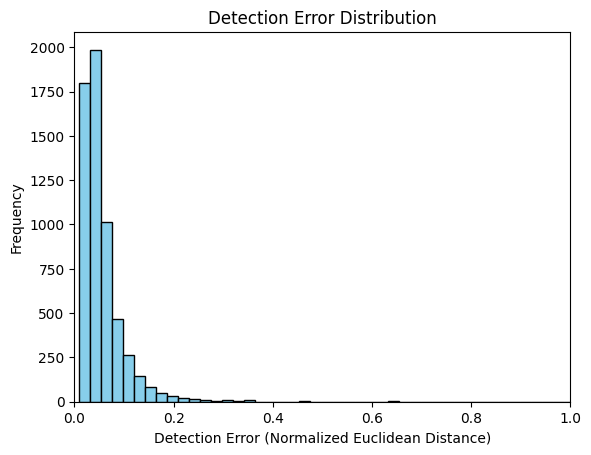

In [301]:
# Plot the detection_errors as a histogram
per_keypoint_detection_error = np.array(detection_errors) / 21
plt.hist(per_keypoint_detection_error, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Detection Error (Normalized Euclidean Distance)')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.title('Detection Error Distribution')
plt.show()

# Let's examine whether our annotations are in accordance with MediaPipe

In [321]:
# For every FILE_NAME, there are 2 rows, one for each hand
# To validate the annotations, for every two rows with the same FILE_NAME the handedness must be different
# out of the two rows, if a row has HANDEDNESS larger than the other row then it also must have WRIST_y lower than the other row
def find_violating_rows(df):
    """
    Identifies rows in a DataFrame that violate the specified rules related to
    handedness and wrist position for pairs of files.

    Args:
        df: A pandas DataFrame with columns "FILE_NAME", "HANDEDNESS", and "WRIST_y".

    Returns:
        A pandas DataFrame containing only the rows that violate the rules.
    """

    violating_rows = pd.DataFrame(columns=df.columns)

    for file_name in df["FILE_NAME"].unique():
        file_df = df[df["FILE_NAME"] == file_name]

        if len(file_df) != 2:
            raise ValueError(
                f"Expected 2 rows for FILE_NAME {file_name}, but found {len(file_df)}"
            )

        row1 = file_df.iloc[0]
        row2 = file_df.iloc[1]

        # Rule 1: Handedness must be different for the two rows
        if row1["HANDEDNESS"] == row2["HANDEDNESS"]:
            violating_rows = pd.concat([violating_rows, file_df], ignore_index=True)
            continue  # Move to the next file if handedness is the same

        # Rule 2: If handedness is larger, wrist_y must be lower
        if (
            row1["HANDEDNESS"] > row2["HANDEDNESS"]
            and row1["WRIST_y"] >= row2["WRIST_y"]
        ) or (
            row1["HANDEDNESS"] < row2["HANDEDNESS"]
            and row1["WRIST_y"] <= row2["WRIST_y"]
        ):
            violating_rows = pd.concat([violating_rows, file_df], ignore_index=True)

    return violating_rows


def correct_handedness(df, offenders):
    """
    Corrects the handedness values in a DataFrame based on a list of offenders.

    Args:
        df: The pandas DataFrame with columns "FILE_NAME", "HAND_ID", and "HANDEDNESS".
        offenders: A list of tuples, where each tuple contains (FILE_NAME, HAND_ID)
                   representing the rows that need correction.

    Returns:
        A new pandas DataFrame with the corrected handedness values.
    """

    df_corrected = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for file_name, hand_id in offenders:
        # Find the index of the row to be corrected
        index = df_corrected.index[
            (df_corrected["FILE_NAME"] == file_name)
            & (df_corrected["HAND_ID"] == hand_id)
        ].tolist()

        if not index:
            print(
                f"Warning: No matching row found for FILE_NAME: {file_name}, HAND_ID: {hand_id}"
            )
            continue

        # Get the handedness value to flip
        row_index = index[0]
        current_handedness = df_corrected.loc[row_index, "HANDEDNESS"]

        # Flip the handedness value (assuming it's numerical)
        # Get the other row with the same FILE_NAME
        other_row_index = df_corrected.index[
            (df_corrected["FILE_NAME"] == file_name)
            & (df_corrected["HAND_ID"] != hand_id)
        ].tolist()[0]
        other_handedness = df_corrected.loc[other_row_index, "HANDEDNESS"]

        df_corrected.loc[row_index, "HANDEDNESS"] = other_handedness

    return df_corrected


def check_our_annotations(
    path_to_images, detector, path_to_our_labels, path_to_generated_labels
):
    # Detecting keypoints on our images
    # if empty, generate labels
    if not os.listdir(path_to_generated_labels):
        print("Detecting")
        make_hand_keypoint_label_files(
            path_to_image_dir=path_to_images,
            detector=detector,
            path_to_output_dir=path_to_generated_labels,
        )
    # Loading our annotations
    our_annotations = load_df_mp_hand_keypoints(path_to_our_labels)
    generated_annotations = load_df_mp_hand_keypoints(path_to_generated_labels)
    
    
    violations = find_violating_rows(generated_annotations)
    # Print the violating rows
    print("Violating Rows:")
    print(violations["FILE_NAME"])
    # In generated_annotations lets correct it
    generated_annotations.loc[145, 'HANDEDNESS'] = 1
    generated_annotations.loc[146, 'HANDEDNESS'] = 1
    generated_annotations.loc[21, 'HANDEDNESS'] = 1
    violations = find_violating_rows(generated_annotations)
    # Print the violating rows
    print("Violating Rows 2222222222222222222:")
    print(violations["FILE_NAME"])

    # Check that FILE_NAME column is the same
    print("Checking that FILE_NAME column is the same")
    print(our_annotations["FILE_NAME"].equals(generated_annotations["FILE_NAME"]))
    # Check Same order
    print("Checking that the order of FILE_NAME column is the same")
    print(
        our_annotations["FILE_NAME"].tolist()
        == generated_annotations["FILE_NAME"].tolist()
    )
    # Generate BBOX for our annotations
    our_annotations_bounding_boxes = generate_df_bounding_boxes(
        our_annotations, keypoints_mask=hand_keypoints_names.values()
    )
    our_annotations_bounding_boxes.index = our_annotations.index
    our_annotations = pd.concat(
        [our_annotations, our_annotations_bounding_boxes], axis=1
    )

    # Generate BBOX for generated annotations
    generated_annotations_bounding_boxes = generate_df_bounding_boxes(
        generated_annotations, keypoints_mask=hand_keypoints_names.values()
    )
    generated_annotations_bounding_boxes.index = generated_annotations.index
    generated_annotations = pd.concat(
        [generated_annotations, generated_annotations_bounding_boxes], axis=1
    )

    # Transform to normalized space
    our_annotations_normalized = transform_to_normalized_space(
        our_annotations, hand_keypoints_names.values()
    )
    generated_annotations_normalized = transform_to_normalized_space(
        generated_annotations, hand_keypoints_names.values()
    )

    # Set index as "FILE_NAME" with combination of "HANDEDNESS"
    our_annotations_normalized.set_index(["FILE_NAME", "HANDEDNESS"], inplace=True)
    generated_annotations_normalized.set_index(
        ["FILE_NAME", "HANDEDNESS"], inplace=True
    )

    # Sort on index
    our_annotations_normalized.sort_index(inplace=True)
    generated_annotations_normalized.sort_index(inplace=True)

    detection_errors = get_cummulative_spatial_error(
        our_annotations_normalized,
        generated_annotations_normalized,
        hand_keypoints_names.values(),
    )
    MCSE = get_mean_cummulative_spatial_error(
        our_annotations_normalized,
        generated_annotations_normalized,
        hand_keypoints_names.values(),
    )
    # calculate squared residuals per column as series

    SS = {}
    for flat_column in flattened_keypoint_names:
        SS[flat_column] = (
            our_annotations[flat_column] - generated_annotations[flat_column]
        ) ** 2

    # Turn SS into a DataFrame
    SS_df = pd.DataFrame(SS)

    return (
        detection_errors,
        MCSE,
        SS_df,
        our_annotations_normalized,
        generated_annotations_normalized,
    )


RGB_detection_errors, RGB_MCSE, RGB_SS_df, our_an_norm, gen_an_norm = (
    check_our_annotations(
        path_to_images="our_hands_dataset/RGB_JPG",
        detector=two_hand_detector,
        path_to_our_labels="our_hands_dataset/LABELS_RGB",
        path_to_generated_labels="our_hands_dataset/LABELS_RGB_MP",
    )
)

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 8888.12it/s]
C:\Users\Marek Tran\AppData\Local\Temp\ipykernel_4204\1219752047.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  violating_rows = pd.concat([violating_rows, file_df], ignore_index=True)


Violating Rows:
0     1_IMG_4554.json
1     1_IMG_4554.json
2    76_IMG_4629.json
3    76_IMG_4629.json
4    77_IMG_4630.json
5    77_IMG_4630.json
Name: FILE_NAME, dtype: object
Violating Rows 2222222222222222222:
Series([], Name: FILE_NAME, dtype: object)
Checking that FILE_NAME column is the same
True
Checking that the order of FILE_NAME column is the same
True


In [323]:
RGB_MCSE/21

0.08606853421385645

Mean Cumulative Spatial Error for RGB: 1.8074


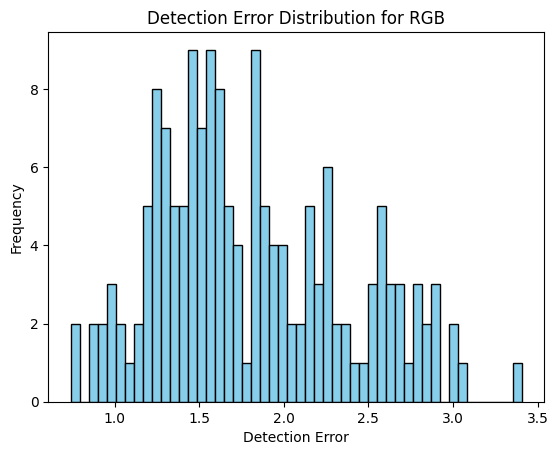

Number of keypoints with error above 0.8: 0


In [324]:
print(f"Mean Cumulative Spatial Error for RGB: {RGB_MCSE:.4f}")

# Plot the detection_errors as a histogram
RGB_per_keypoint_detection_error = np.array(RGB_detection_errors) / 21
plt.hist(RGB_per_keypoint_detection_error, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Detection Error (Normalized Euclidean Distance per kp)')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.title('Detection Error Distribution for RGB')
plt.show()



In [304]:
# For column in SS_df.columns: calculate the mean for that column and print
for column in RGB_SS_df.columns:
  print(f"Mean Squared Error for {column}: {RGB_SS_df[column].mean()}")

Mean Squared Error for WRIST_x: 0.0005667121629640056
Mean Squared Error for WRIST_y: 0.021798178750569754
Mean Squared Error for THUMB_CMC_x: 0.0005653401494771932
Mean Squared Error for THUMB_CMC_y: 0.038777203452212604
Mean Squared Error for THUMB_MCP_x: 0.0008220046822733316
Mean Squared Error for THUMB_MCP_y: 0.054287776467083826
Mean Squared Error for THUMB_IP_x: 0.0009522475346487414
Mean Squared Error for THUMB_IP_y: 0.06423098241904007
Mean Squared Error for THUMB_TIP_x: 0.001200342969811241
Mean Squared Error for THUMB_TIP_y: 0.07840771915366544
Mean Squared Error for INDEX_FINGER_MCP_x: 0.0004423340346111539
Mean Squared Error for INDEX_FINGER_MCP_y: 0.028341329688764755
Mean Squared Error for INDEX_FINGER_PIP_x: 0.00041206444828600816
Mean Squared Error for INDEX_FINGER_PIP_y: 0.030264511117603633
Mean Squared Error for INDEX_FINGER_DIP_x: 0.00038737798245439025
Mean Squared Error for INDEX_FINGER_DIP_y: 0.030954193001820486
Mean Squared Error for INDEX_FINGER_TIP_x: 0.0003

In [305]:
# Print rows with anomalous detection errors
anomalous_row_our_annotations = our_an_norm.iloc[np.where(np.array(RGB_per_keypoint_detection_error) > 0.8)] 
anomalous_row_generated_annotations = gen_an_norm.iloc[np.where(np.array(RGB_per_keypoint_detection_error) > 0.8)]
anomalous_row_generated_annotations


HAND_ID   WRIST_x   WRIST_y  THUMB_CMC_x  \
FILE_NAME        HANDEDNESS                                             
77_IMG_4630.json 0                 0  0.222809 -0.883005    -0.250696   
                 0                 1 -0.288815 -0.874153     0.148706   

                             THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  \
FILE_NAME        HANDEDNESS                                          
77_IMG_4630.json 0             -0.717714    -0.563508    -0.426319   
                 0             -0.683043     0.468693    -0.428341   

                             THUMB_IP_x  THUMB_IP_y  THUMB_TIP_x  ...  \
FILE_NAME        HANDEDNESS                                       ...   
77_IMG_4630.json 0            -0.724048   -0.123998    -0.938360  ...   
                 0             0.696025   -0.214298     0.909514  ...   

                             PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  \
FILE_NAME        HANDEDNESS                                          
77_IMG_4630.json 0               0.14898     0.810055     0.355065   
                 0               0.25409    -0.819364     0.446846   

                             PINKY_TIP_x  PINKY_TIP_y     BB_CX     BB_CY  \
FILE_NAME        HANDEDNESS                                                 
77_IMG_4630.json 0              0.822847     0.538931  0.532552  0.453145   
                 0             -0.820950     0.617201  0.554635  0.675703   

                                 BB_W      BB_H    ROT_DEG  
FILE_NAME        HANDEDNESS                                 
77_IMG_4630.json 0           0.252497  0.150734 -79.225419  
                 0           0.273379  0.155655 -99.202718  

[2 rows x 48 columns]

In [306]:
anomalous_row_generated_annotations

HAND_ID   WRIST_x   WRIST_y  THUMB_CMC_x  \
FILE_NAME        HANDEDNESS                                             
77_IMG_4630.json 0                 0  0.222809 -0.883005    -0.250696   
                 0                 1 -0.288815 -0.874153     0.148706   

                             THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  \
FILE_NAME        HANDEDNESS                                          
77_IMG_4630.json 0             -0.717714    -0.563508    -0.426319   
                 0             -0.683043     0.468693    -0.428341   

                             THUMB_IP_x  THUMB_IP_y  THUMB_TIP_x  ...  \
FILE_NAME        HANDEDNESS                                       ...   
77_IMG_4630.json 0            -0.724048   -0.123998    -0.938360  ...   
                 0             0.696025   -0.214298     0.909514  ...   

                             PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  \
FILE_NAME        HANDEDNESS                                          
77_IMG_4630.json 0               0.14898     0.810055     0.355065   
                 0               0.25409    -0.819364     0.446846   

                             PINKY_TIP_x  PINKY_TIP_y     BB_CX     BB_CY  \
FILE_NAME        HANDEDNESS                                                 
77_IMG_4630.json 0              0.822847     0.538931  0.532552  0.453145   
                 0             -0.820950     0.617201  0.554635  0.675703   

                                 BB_W      BB_H    ROT_DEG  
FILE_NAME        HANDEDNESS                                 
77_IMG_4630.json 0           0.252497  0.150734 -79.225419  
                 0           0.273379  0.155655 -99.202718  

[2 rows x 48 columns]

In [307]:
tmp_check = get_cummulative_spatial_error(anomalous_row_our_annotations, anomalous_row_generated_annotations, hand_keypoints_names.values())
tmp_check = np.array(tmp_check) / 21
tmp_check

array([0.87119833, 0.82417732])

In [308]:
# Lets draw this file 77_IMG_4630.json with the generated keypoints and handedness detection:
temp_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB_MP')
# Get index of the file
temp_df[temp_df['FILE_NAME'] == '77_IMG_4630.json']

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 8888.83it/s]


FILE_NAME  HAND_ID  HANDEDNESS   WRIST_x   WRIST_y  THUMB_CMC_x  \
146  77_IMG_4630.json        0           0  0.647323  0.457201     0.615648   
147  77_IMG_4630.json        1           0  0.678898  0.664395     0.643547   

     THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  THUMB_IP_x  ...  \
146     0.424472     0.572126     0.405418    0.530842  ...   
147     0.695629     0.602185     0.717042    0.568335  ...   

     RING_FINGER_TIP_x  RING_FINGER_TIP_y  PINKY_MCP_x  PINKY_MCP_y  \
146           0.439278           0.505672     0.566548     0.500213   
147           0.449467           0.626494     0.576692     0.619955   

     PINKY_PIP_x  PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  PINKY_TIP_x  \
146     0.532230     0.512197     0.507635     0.518123     0.485133   
147     0.537954     0.610673     0.512253     0.607193     0.489302   

     PINKY_TIP_y  
146     0.521661  
147     0.604951  

[2 rows x 45 columns]

In [309]:
def process_strings(strings):
    return list({s[:-2] for s in strings if s.endswith('_x') or s.endswith('_y')})

def add_bounding_box_columns(df, keypoints_mask):
    if 'BB_CX' in df.columns:
        return df
    # Generate BBOX for our annotations
    df_bounding_boxes = generate_df_bounding_boxes(df, keypoints_mask)
    df_bounding_boxes.index = df.index
    df = pd.concat([df, df_bounding_boxes], axis=1)
    return df

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 9998.64it/s]

Checking that FILE_NAME column is the same
FILE ORDER IS SAME True
Checking that the order of FILE_NAME column is the same
ORDER IS SAME True
RAW MCSE: 2.0982
28_IMG_4581.json


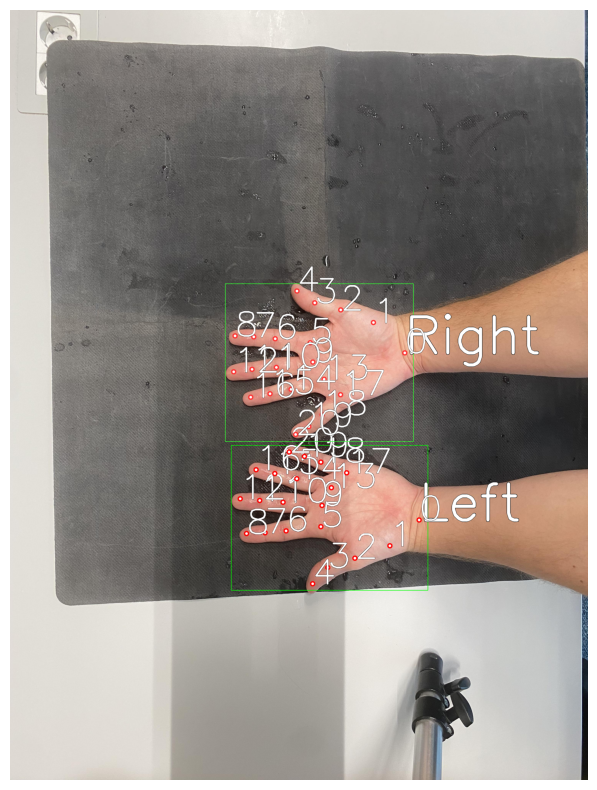

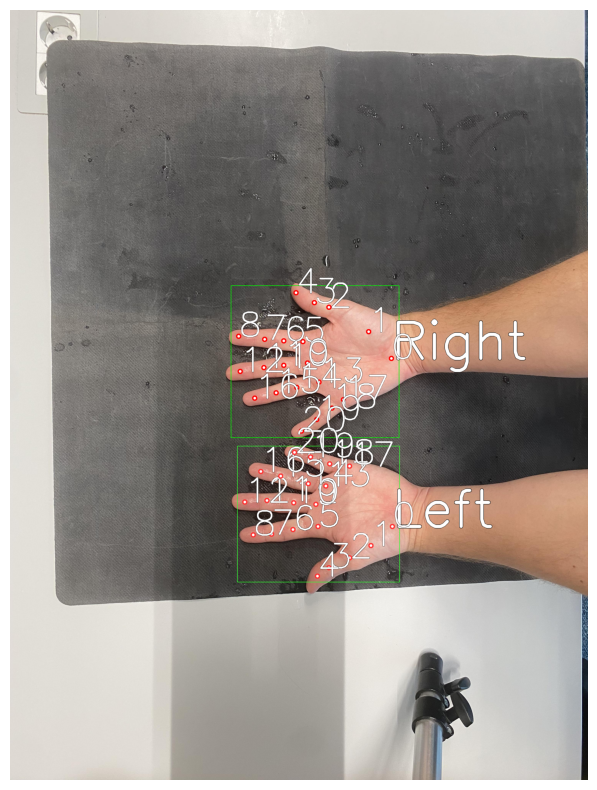

17.50717901644078


In [310]:
anomalous_row_our_annotations = our_an_norm.iloc[np.where(np.array(RGB_per_keypoint_detection_error) < 0.1)] 
anomalous_row_generated_annotations = gen_an_norm.iloc[np.where(np.array(RGB_per_keypoint_detection_error) < 0.1)]
anomalous_row_our_annotations
temp_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB_MP')
ttemp_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB')

print("Checking that FILE_NAME column is the same")
print("FILE ORDER IS SAME",temp_df['FILE_NAME'].equals(ttemp_df['FILE_NAME']))
# Check Same order
print("Checking that the order of FILE_NAME column is the same")
print("ORDER IS SAME",temp_df['FILE_NAME'].tolist() == ttemp_df['FILE_NAME'].tolist())

difference_handedness = ttemp_df.copy()
difference_handedness['HANDEDNESS'] = ttemp_df['HANDEDNESS'] == temp_df['HANDEDNESS']


# temp_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB_MP')
temp_df = add_bounding_box_columns(temp_df, process_strings(temp_df.columns))
ttemp_df = add_bounding_box_columns(ttemp_df, process_strings(ttemp_df.columns))



raw_mcse = get_mean_cummulative_spatial_error(temp_df, ttemp_df, hand_keypoints_names.values())
print(f"RAW MCSE: {raw_mcse:.4f}")
anomalous_row_our_annotations.reset_index(inplace=True)
anomalous_row_our_annotations
# GET RANDOM FILE_NAME from anomalous_row_our_annotations
# Get list of file names but no duplicates
anomalous_file_names_no_dupes = anomalous_row_our_annotations['FILE_NAME'].unique()
# Get random file name
random_file_name_anomalous = random.choice(anomalous_file_names_no_dupes)
print(random_file_name_anomalous)
attempt_to_draw_from_df(temp_df, random_file_name_anomalous, ["our_hands_dataset/FOLDER_FOR_DRAWING"], hand_keypoints_names.values(), figsize=(10,10), font_scale=12, font_thickness=20, point_size=14)
attempt_to_draw_from_df(ttemp_df, random_file_name_anomalous, ["our_hands_dataset/FOLDER_FOR_DRAWING"], hand_keypoints_names.values(), figsize=(10,10), font_scale=12, font_thickness=20, point_size=14)


normalized_single_image_gen = transform_to_normalized_space(temp_df[temp_df['FILE_NAME'] == random_file_name_anomalous], hand_keypoints_names.values())
normalized_single_image_an = transform_to_normalized_space(ttemp_df[ttemp_df['FILE_NAME'] == random_file_name_anomalous], hand_keypoints_names.values())
# Calculate the mean squared error for this image
print(get_mean_cummulative_spatial_error(normalized_single_image_gen, normalized_single_image_an, hand_keypoints_names.values()))

In [311]:
difference_handedness

FILE_NAME  HAND_ID  HANDEDNESS   WRIST_x   WRIST_y  THUMB_CMC_x  \
0    10_IMG_4563.json        0        True  0.621693  0.463790     0.601852   
1    10_IMG_4563.json        1        True  0.631614  0.629960     0.610119   
2    11_IMG_4564.json        0        True  0.641534  0.434028     0.633267   
3    11_IMG_4564.json        1        True  0.646495  0.596478     0.628307   
4    12_IMG_4565.json        0       False  0.658069  0.456349     0.636574   
..                ...      ...         ...       ...       ...          ...   
155  80_IMG_4633.json        1       False  0.593348  0.608702     0.599017   
156   8_IMG_4561.json        0       False  0.651455  0.483631     0.643188   
157   8_IMG_4561.json        1       False  0.672950  0.647321     0.648148   
158   9_IMG_4562.json        0        True  0.586971  0.465030     0.575397   
159   9_IMG_4562.json        1        True  0.588624  0.652282     0.560516   

     THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  THUMB_IP_x  ...  \
0       0.434028     0.552249     0.412946    0.512566  ...   
1       0.654762     0.565476     0.682044    0.532407  ...   
2       0.401786     0.582011     0.373264    0.539021  ...   
3       0.627480     0.573743     0.658482    0.543981  ...   
4       0.429067     0.585317     0.394345    0.555556  ...   
..           ...          ...          ...         ...  ...   
155     0.651219     0.589569     0.693027    0.546107  ...   
156     0.457589     0.603505     0.426587    0.565476  ...   
157     0.677083     0.601852     0.694444    0.568783  ...   
158     0.435268     0.529101     0.425347    0.484458  ...   
159     0.684524     0.524140     0.700645    0.492725  ...   

     RING_FINGER_TIP_x  RING_FINGER_TIP_y  PINKY_MCP_x  PINKY_MCP_y  \
0             0.406746           0.517113     0.524140     0.513393   
1             0.406746           0.582837     0.519180     0.579117   
2             0.429894           0.469990     0.543981     0.473710   
3             0.418320           0.567956     0.529101     0.559276   
4             0.439815           0.493552     0.548942     0.497272   
..                 ...                ...          ...          ...   
155           0.356198           0.638464     0.489418     0.598781   
156           0.458003           0.522073     0.577050     0.524554   
157           0.453042           0.611359     0.563823     0.598958   
158           0.388558           0.522073     0.507606     0.518353   
159           0.370370           0.595238     0.496032     0.596478   

     PINKY_PIP_x  PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  PINKY_TIP_x  \
0       0.499339     0.522073     0.472884     0.530754     0.454696   
1       0.489418     0.570437     0.464616     0.567956     0.444775   
2       0.519180     0.478671     0.499339     0.488591     0.472884   
3       0.509259     0.554315     0.484458     0.553075     0.453042   
4       0.519180     0.507192     0.497685     0.509673     0.472884   
..           ...          ...          ...          ...          ...   
155     0.449735     0.593112     0.417611     0.585317     0.382653   
156     0.540675     0.536954     0.515873     0.539435     0.494378   
157     0.527447     0.591518     0.502646     0.586558     0.477844   
158     0.481151     0.531994     0.458003     0.539435     0.429894   
159     0.467923     0.589038     0.443122     0.582837     0.411706   

     PINKY_TIP_y  
0       0.531994  
1       0.566716  
2       0.489831  
3       0.550595  
4       0.515873  
..           ...  
155     0.581774  
156     0.543155  
157     0.590278  
158     0.544395  
159     0.579117  

[160 rows x 45 columns]

In [318]:
# import Image
from PIL import Image
def check_our_annotations_MNAE(path_to_images, detector, path_to_our_labels, path_to_generated_labels):
    # Detecting keypoints on our images
    # if empty, generate labels
    if not os.listdir(path_to_generated_labels):
        print("Detecting")
        make_hand_keypoint_label_files(path_to_image_dir=path_to_images, detector=detector, path_to_output_dir=path_to_generated_labels)
    # Take an image from path_to_image_dir and get the resolution of the image
    image = Image.open(os.path.join(path_to_images, os.listdir(path_to_images)[0]))
    width, height = image.size
    # Loading our annotations
    our_annotations = load_df_mp_hand_keypoints(path_to_our_labels)
    generated_annotations = load_df_mp_hand_keypoints(path_to_generated_labels)
    generated_annotations.loc[145, 'HANDEDNESS'] = 1
    generated_annotations.loc[146, 'HANDEDNESS'] = 1
    generated_annotations.loc[21, 'HANDEDNESS'] = 1
    # Check that FILE_NAME column is the same
    print("Checking that FILE_NAME column is the same")
    print(our_annotations['FILE_NAME'].equals(generated_annotations['FILE_NAME']))
    # Check Same order
    print("Checking that the order of FILE_NAME column is the same")
    print(our_annotations['FILE_NAME'].tolist() == generated_annotations['FILE_NAME'].tolist())
    # Set index to be combination of FILE_NAME and HANDEDNESS
    our_annotations.set_index(["FILE_NAME", "HANDEDNESS"], inplace=True)
    generated_annotations.set_index(["FILE_NAME", "HANDEDNESS"], inplace=True)

    # Sort on index
    our_annotations.sort_index(inplace=True)
    generated_annotations.sort_index(inplace=True)

    # Multiply all columns ending with _x by width and all columns ending with _y by height
    for column in our_annotations.columns:
        if column.endswith('_x'):
            our_annotations[column] = our_annotations[column] * width
        elif column.endswith('_y'):
            our_annotations[column] = our_annotations[column] * height
    for column in generated_annotations.columns:
        if column.endswith('_x'):
            generated_annotations[column] = generated_annotations[column] * width
        elif column.endswith('_y'):
            generated_annotations[column] = generated_annotations[column] * height
    # So now the prediction and ground truth have the same index
    # Calculate the pixel distance for every row between the keypoints WRIST and MIDDLE_FINGER_MCP which corresponds to columns WRIST_x, WRIST_y and MIDDLE_FINGER_MCP_x, MIDDLE_FINGER_MCP_y
    # RESULT DF
    result_mae_df = pd.DataFrame(columns=[c+"_AE" for c in hand_keypoints_names.values()])
    
    result_mae_df['PALM_SIZE'] = np.sqrt((our_annotations['WRIST_x'] - our_annotations['MIDDLE_FINGER_MCP_x'])**2 + (our_annotations['WRIST_y'] - our_annotations['MIDDLE_FINGER_MCP_y'])**2)
    
    # Calculate ae between our_annotations and generated_annotations
    for column in hand_keypoints_names.values():
        result_mae_df[column+"_AE"] = np.sqrt((our_annotations[column+'_x'] - generated_annotations[column+'_x'])**2 + (our_annotations[column+'_y'] - generated_annotations[column+'_y'])**2)

    # Normalize AE by PALM_SIZE
    for column in hand_keypoints_names.values():
        result_mae_df[column+"_AE"] = result_mae_df[column+"_AE"] / result_mae_df['PALM_SIZE']

    # SUM of NAE 
    result_mae_df['SUM_NAE'] = result_mae_df[[c+"_AE" for c in hand_keypoints_names.values()]].sum(axis=1)
    # Print mean of SUM_NAE column
    print(f"Mean of SUM_NAE: {result_mae_df['SUM_NAE'].mean()}")
    # Print standard deviation of SUM_NAE column
    print(f"Standard deviation of SUM_NAE: {result_mae_df['SUM_NAE'].std()}")
    # Print stdev in %
    

    
    return our_annotations, generated_annotations, result_mae_df
our, gen, resmae = check_our_annotations_MNAE(path_to_images='our_hands_dataset/RGB_JPG', detector=two_hand_detector, path_to_our_labels='our_hands_dataset/LABELS_RGB', path_to_generated_labels='our_hands_dataset/LABELS_RGB_MP')
resmae

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 8000.39it/s]

Checking that FILE_NAME column is the same
True
Checking that the order of FILE_NAME column is the same
True
Mean of SUM_NAE: 1.2573602574522877
Standard deviation of SUM_NAE: 0.4501060006846808


WRIST_AE  THUMB_CMC_AE  THUMB_MCP_AE  \
FILE_NAME        HANDEDNESS                                         
10_IMG_4563.json 0           0.044250      0.057375      0.021858   
                 1           0.066128      0.073808      0.006004   
11_IMG_4564.json 0           0.034167      0.071517      0.051732   
                 1           0.162412      0.106599      0.072383   
12_IMG_4565.json 0           0.015096      0.097281      0.014631   
...                               ...           ...           ...   
80_IMG_4633.json 1           0.151478      0.070981      0.118099   
8_IMG_4561.json  0           0.075717      0.053933      0.075190   
                 1           0.190010      0.099719      0.047634   
9_IMG_4562.json  0           0.083122      0.057649      0.012430   
                 1           0.148595      0.065658      0.028017   

                             THUMB_IP_AE  THUMB_TIP_AE  INDEX_FINGER_MCP_AE  \
FILE_NAME        HANDEDNESS                                                   
10_IMG_4563.json 0              0.032843      0.051645             0.135462   
                 1              0.034614      0.052171             0.110183   
11_IMG_4564.json 0              0.072956      0.050908             0.078318   
                 1              0.028432      0.072324             0.135797   
12_IMG_4565.json 0              0.030765      0.037071             0.089790   
...                                  ...           ...                  ...   
80_IMG_4633.json 1              0.063554      0.046156             0.045454   
8_IMG_4561.json  0              0.062719      0.083577             0.133810   
                 1              0.021535      0.115330             0.120558   
9_IMG_4562.json  0              0.054586      0.086639             0.113207   
                 1              0.023376      0.110819             0.130215   

                             INDEX_FINGER_PIP_AE  INDEX_FINGER_DIP_AE  \
FILE_NAME        HANDEDNESS                                             
10_IMG_4563.json 0                      0.053182             0.006383   
                 1                      0.052494             0.058624   
11_IMG_4564.json 0                      0.044821             0.020862   
                 1                      0.033338             0.009811   
12_IMG_4565.json 0                      0.022855             0.023657   
...                                          ...                  ...   
80_IMG_4633.json 1                      0.026059             0.017561   
8_IMG_4561.json  0                      0.026453             0.024220   
                 1                      0.032210             0.022733   
9_IMG_4562.json  0                      0.068836             0.044317   
                 1                      0.041407             0.037495   

                             INDEX_FINGER_TIP_AE  MIDDLE_FINGER_MCP_AE  ...  \
FILE_NAME        HANDEDNESS                                             ...   
10_IMG_4563.json 0                      0.027483              0.150007  ...   
                 1                      0.022906              0.149166  ...   
11_IMG_4564.json 0                      0.055196              0.129170  ...   
                 1                      0.019621              0.150032  ...   
12_IMG_4565.json 0                      0.029271              0.093456  ...   
...                                          ...                   ...  ...   
80_IMG_4633.json 1                      0.046729              0.045517  ...   
8_IMG_4561.json  0                      0.072605              0.154412  ...   
                 1                      0.029776              0.215260  ...   
9_IMG_4562.json  0                      0.079987              0.111163  ...   
                 1                      0.084638              0.166695  ...   

                             RING_FINGER_MCP_AE  RING_FINGER_PIP_AE  \
FILE_NAME        HANDEDNESS                           

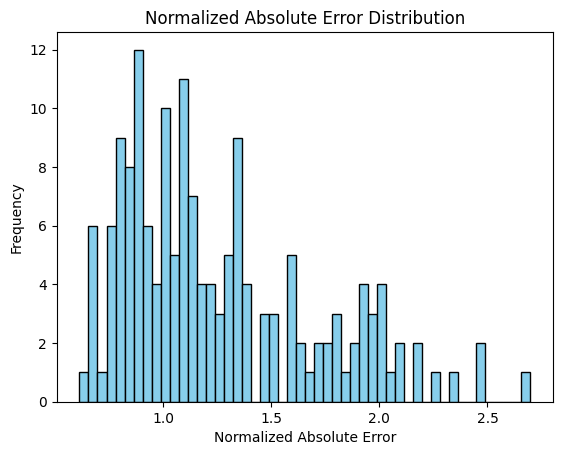

In [319]:
# Plot the resmae[SUM_NAE] as a histogram
plt.hist(resmae['SUM_NAE'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Normalized Absolute Error')
plt.ylabel('Frequency')
plt.title('Normalized Absolute Error Distribution')
plt.show()


In [314]:
# TRIPLE CHECK OUR ANNOTATIONS
ours = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB')
generated = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB_MP')
violations_our = find_violating_rows(ours)
violations_gen = find_violating_rows(generated)
# Print the violating rows
print("Violating Rows:")
print(violations_our["FILE_NAME"])
# In generated_annotations lets correct it
print(violations_gen["FILE_NAME"])


Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 9998.64it/s]
C:\Users\Marek Tran\AppData\Local\Temp\ipykernel_4204\2017434695.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  violating_rows = pd.concat([violating_rows, file_df], ignore_index=True)


Violating Rows:
Series([], Name: FILE_NAME, dtype: object)
0     1_IMG_4554.json
1     1_IMG_4554.json
2    76_IMG_4629.json
3    76_IMG_4629.json
4    77_IMG_4630.json
5    77_IMG_4630.json
Name: FILE_NAME, dtype: object


In [269]:
ours


FILE_NAME  HAND_ID  HANDEDNESS   WRIST_x   WRIST_y  THUMB_CMC_x  \
0    10_IMG_4563.json        0           1  0.621693  0.463790     0.601852   
1    10_IMG_4563.json        1           0  0.631614  0.629960     0.610119   
2    11_IMG_4564.json        0           1  0.641534  0.434028     0.633267   
3    11_IMG_4564.json        1           0  0.646495  0.596478     0.628307   
4    12_IMG_4565.json        0           1  0.658069  0.456349     0.636574   
..                ...      ...         ...       ...       ...          ...   
155  80_IMG_4633.json        1           0  0.593348  0.608702     0.599017   
156   8_IMG_4561.json        0           1  0.651455  0.483631     0.643188   
157   8_IMG_4561.json        1           0  0.672950  0.647321     0.648148   
158   9_IMG_4562.json        0           1  0.586971  0.465030     0.575397   
159   9_IMG_4562.json        1           0  0.588624  0.652282     0.560516   

     THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  THUMB_IP_x  ...  \
0       0.434028     0.552249     0.412946    0.512566  ...   
1       0.654762     0.565476     0.682044    0.532407  ...   
2       0.401786     0.582011     0.373264    0.539021  ...   
3       0.627480     0.573743     0.658482    0.543981  ...   
4       0.429067     0.585317     0.394345    0.555556  ...   
..           ...          ...          ...         ...  ...   
155     0.651219     0.589569     0.693027    0.546107  ...   
156     0.457589     0.603505     0.426587    0.565476  ...   
157     0.677083     0.601852     0.694444    0.568783  ...   
158     0.435268     0.529101     0.425347    0.484458  ...   
159     0.684524     0.524140     0.700645    0.492725  ...   

     RING_FINGER_TIP_x  RING_FINGER_TIP_y  PINKY_MCP_x  PINKY_MCP_y  \
0             0.406746           0.517113     0.524140     0.513393   
1             0.406746           0.582837     0.519180     0.579117   
2             0.429894           0.469990     0.543981     0.473710   
3             0.418320           0.567956     0.529101     0.559276   
4             0.439815           0.493552     0.548942     0.497272   
..                 ...                ...          ...          ...   
155           0.356198           0.638464     0.489418     0.598781   
156           0.458003           0.522073     0.577050     0.524554   
157           0.453042           0.611359     0.563823     0.598958   
158           0.388558           0.522073     0.507606     0.518353   
159           0.370370           0.595238     0.496032     0.596478   

     PINKY_PIP_x  PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  PINKY_TIP_x  \
0       0.499339     0.522073     0.472884     0.530754     0.454696   
1       0.489418     0.570437     0.464616     0.567956     0.444775   
2       0.519180     0.478671     0.499339     0.488591     0.472884   
3       0.509259     0.554315     0.484458     0.553075     0.453042   
4       0.519180     0.507192     0.497685     0.509673     0.472884   
..           ...          ...          ...          ...          ...   
155     0.449735     0.593112     0.417611     0.585317     0.382653   
156     0.540675     0.536954     0.515873     0.539435     0.494378   
157     0.527447     0.591518     0.502646     0.586558     0.477844   
158     0.481151     0.531994     0.458003     0.539435     0.429894   
159     0.467923     0.589038     0.443122     0.582837     0.411706   

     PINKY_TIP_y  
0       0.531994  
1       0.566716  
2       0.489831  
3       0.550595  
4       0.515873  
..           ...  
155     0.581774  
156     0.543155  
157     0.590278  
158     0.544395  
159     0.579117  

[160 rows x 45 columns]

In [270]:
generated

FILE_NAME  HAND_ID  HANDEDNESS   WRIST_x   WRIST_y  THUMB_CMC_x  \
0    10_IMG_4563.json        0           1  0.630462  0.463614     0.593227   
1    10_IMG_4563.json        1           0  0.637980  0.629468     0.605515   
2    11_IMG_4564.json        0           1  0.659265  0.425546     0.621550   
3    11_IMG_4564.json        1           0  0.650010  0.599060     0.619963   
4    12_IMG_4565.json        0           0  0.664900  0.614317     0.636990   
..                ...      ...         ...       ...       ...          ...   
155  80_IMG_4633.json        1           1  0.588288  0.463392     0.551044   
156   8_IMG_4561.json        0           0  0.681849  0.652143     0.645194   
157   8_IMG_4561.json        1           1  0.674381  0.480998     0.640054   
158   9_IMG_4562.json        0           1  0.605199  0.468774     0.568815   
159   9_IMG_4562.json        1           0  0.597479  0.647548     0.565315   

     THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  THUMB_IP_x  ...  \
0       0.430551     0.552218     0.412350    0.516614  ...   
1       0.659940     0.566373     0.684317    0.530140  ...   
2       0.396314     0.578389     0.379748    0.538872  ...   
3       0.632008     0.580567     0.656241    0.542341  ...   
4       0.648519     0.598342     0.671984    0.562990  ...   
..           ...          ...          ...         ...  ...   
155     0.429651     0.503816     0.406582    0.454430  ...   
156     0.682514     0.602178     0.702617    0.562690  ...   
157     0.448768     0.602287     0.430851    0.566938  ...   
158     0.439123     0.526578     0.423460    0.486041  ...   
159     0.680161     0.524300     0.701859    0.486028  ...   

     RING_FINGER_TIP_x  RING_FINGER_TIP_y  PINKY_MCP_x  PINKY_MCP_y  \
0             0.415100           0.512505     0.542616     0.507871   
1             0.413515           0.583284     0.540457     0.583554   
2             0.432790           0.473086     0.562547     0.470100   
3             0.421944           0.569822     0.548346     0.560771   
4             0.435523           0.587703     0.563572     0.575463   
..                 ...                ...          ...          ...   
155           0.335146           0.506054     0.474860     0.510365   
156           0.453068           0.613028     0.580249     0.604009   
157           0.464820           0.521652     0.585842     0.523935   
158           0.391956           0.524693     0.520192     0.515942   
159           0.378510           0.598513     0.506197     0.599310   

     PINKY_PIP_x  PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  PINKY_TIP_x  \
0       0.505557     0.521527     0.481470     0.528895     0.457209   
1       0.501635     0.573712     0.475704     0.570963     0.451916   
2       0.524826     0.482107     0.498689     0.486792     0.474434   
3       0.506623     0.554048     0.480922     0.552533     0.457397   
4       0.524191     0.567634     0.497773     0.566293     0.473449   
..           ...          ...          ...          ...          ...   
155     0.433868     0.523951     0.405829     0.530915     0.378604   
156     0.542128     0.594441     0.516847     0.591770     0.492840   
157     0.550760     0.535600     0.525831     0.540727     0.500665   
158     0.483456     0.530724     0.458846     0.538441     0.435648   
159     0.468806     0.587712     0.443849     0.582690     0.420098   

     PINKY_TIP_y  
0       0.533169  
1       0.569361  
2       0.489217  
3       0.550929  
4       0.565694  
..           ...  
155     0.534826  
156     0.590494  
157     0.542567  
158     0.543971  
159     0.578537  

[160 rows x 45 columns]

# Begin Experiments

First: Dataset pre-processing

In [107]:
seed = 7

hand_keypoints_no_pinky_MCP = [kp for kp in hand_keypoints_names.values() if "PINKY_MCP" != kp]
flattened_hand_keypoints_no_pinky_MCP = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() if "PINKY_MCP" != v for axis in ["x", "y"]]

# hand keypoints no THUMB_CMC
hand_keypoints_no_thumb_CMC = [kp for kp in hand_keypoints_names.values() if "THUMB_CMC" != kp]
flattened_hand_keypoints_no_thumb_CMC = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() if "THUMB_CMC" != v for axis in ["x", "y"]]

In [108]:
# FIRST HAGRID DATASET

# This is palm fingers apart
hagrid_palm_train_df = load_hagrid('F:/hagrid/data/annotations/train/palm.json')
hagrid_palm_val_df = load_hagrid('F:/hagrid/data/annotations/val/palm.json')
hagrid_palm_test_df = load_hagrid('F:/hagrid/data/annotations/test/palm.json')

# This is palm fingers together
hagrid_stop_train_df = load_hagrid('F:/hagrid/data/annotations/train/stop.json')
hagrid_stop_val_df = load_hagrid('F:/hagrid/data/annotations/val/stop.json')
hagrid_stop_test_df = load_hagrid('F:/hagrid/data/annotations/test/stop.json')

# This is dorsal fingers together
hagrid_stopinv_train_df = load_hagrid('F:/hagrid/data/annotations/train/stop_inverted.json')
hagrid_stopinv_val_df = load_hagrid('F:/hagrid/data/annotations/val/stop_inverted.json')
hagrid_stopinv_test_df = load_hagrid('F:/hagrid/data/annotations/test/stop_inverted.json')

# SECOND is 11k HANDS dataset
# Palmar, dorsal fingers together and apart all in one
train_11k_df = load_df_yolo_labels_from_dir('hand-keypoints/train/labels')
val_11k_df = load_df_yolo_labels_from_dir('hand-keypoints/val/labels')

# DROP NA from all
hagrid_palm_train_df = hagrid_palm_train_df.dropna()
hagrid_palm_val_df = hagrid_palm_val_df.dropna()
hagrid_palm_test_df = hagrid_palm_test_df.dropna()
hagrid_stop_train_df = hagrid_stop_train_df.dropna()
hagrid_stop_val_df = hagrid_stop_val_df.dropna()
hagrid_stop_test_df = hagrid_stop_test_df.dropna()
hagrid_stopinv_train_df = hagrid_stopinv_train_df.dropna()
hagrid_stopinv_val_df = hagrid_stopinv_val_df.dropna()
hagrid_stopinv_test_df = hagrid_stopinv_test_df.dropna()
train_11k_df = train_11k_df.dropna()
val_11k_df = val_11k_df.dropna()


# Print the length of each dataframe
print("Hagrid Palm Train:", len(hagrid_palm_train_df))
print("Hagrid Palm Val:", len(hagrid_palm_val_df))
print("Hagrid Palm Test:", len(hagrid_palm_test_df))
print("Hagrid Stop Train:", len(hagrid_stop_train_df))
print("Hagrid Stop Val:", len(hagrid_stop_val_df))
print("Hagrid Stop Test:", len(hagrid_stop_test_df))
print("Hagrid Stopinv Train:", len(hagrid_stopinv_train_df))
print("Hagrid Stopinv Val:", len(hagrid_stopinv_val_df))
print("Hagrid Stopinv Test:", len(hagrid_stopinv_test_df))
print("11k Train:", len(train_11k_df))
print("11k Val:", len(val_11k_df))



Processing Ultralytics YOLO labels: 100%|██████████| 3125/3125 [00:00<00:00, 18712.65it/s]


Hagrid Palm Train: 18536
Hagrid Palm Val: 2294
Hagrid Palm Test: 3974
Hagrid Stop Train: 18224
Hagrid Stop Val: 2234
Hagrid Stop Test: 3953
Hagrid Stopinv Train: 17364
Hagrid Stopinv Val: 2406
Hagrid Stopinv Test: 4007
11k Train: 4642
11k Val: 1991


In [109]:
# Load our_hands dataset
our_hands_rgb_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB', extra_point=True)
our_hands_ir_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_IR', extra_point=True)
our_hands_total = pd.concat([our_hands_rgb_df, our_hands_ir_df])

# Generate bounding boxes
our_hands_total_bounding_boxes_df = generate_df_bounding_boxes(our_hands_total, keypoints_mask = hand_keypoints_names.values())
# Add the columns to the dataframe
our_hands_total_bounding_boxes_df.index = our_hands_total.index
our_hands_total = pd.concat([our_hands_total, our_hands_total_bounding_boxes_df], axis=1)

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 10000.72it/s]


In [110]:
# Rename yolo bbox columns to match my naming convention
train_11k_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)
val_11k_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)

In [111]:
hands_11k_total_df = pd.concat([train_11k_df, val_11k_df])
hands_11k_total_df.sort_values(by=['FILE_NAME'], inplace=True)
hands_11k_total_df.reset_index(drop=True, inplace=True)

# MAKE BIG DATASET

In [112]:
train_11k_df, val_11k_df = train_test_split(hands_11k_total_df, test_size=0.2, shuffle=False)
size_of_clean_11k = int(len(train_11k_df)*1.66)
combined_train_df = pd.concat([train_11k_df, 
                              hagrid_palm_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0), 
                              hagrid_stop_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0), 
                              hagrid_stopinv_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0)])

combined_test_df = pd.concat([val_11k_df,
                              hagrid_palm_val_df, 
                              hagrid_stop_val_df, 
                              hagrid_stopinv_val_df])


In [113]:
# Print length of combined_train_df and combined_test_df
print("Combined Train:", len(combined_train_df))
print("Combined Test:", len(combined_test_df))

Combined Train: 31727
Combined Test: 8261


In [114]:
# Reset index
combined_test_df.reset_index(drop=True, inplace=True)
combined_train_df.reset_index(drop=True, inplace=True)
# Transform to rotated bb space
combined_train_df_normalized = transform_to_normalized_space(combined_train_df, hand_keypoints_names.values())
combined_test_df_normalized = transform_to_normalized_space(combined_test_df, hand_keypoints_names.values())
# do the same for our dataset
our_hands_total.reset_index(drop=True, inplace=True)
our_hands_total_normalized_df = transform_to_normalized_space(our_hands_total, list(hand_keypoints_names.values()) + ["HYPOTHENAR"])
# Do it for hagrid classes so i can have separate tests for one class of gesture
hagrid_palm_test_df.reset_index(drop=True, inplace=True)
hagrid_palm_test_df_normalized = transform_to_normalized_space(hagrid_palm_test_df, hand_keypoints_names.values())
hagrid_stop_test_df.reset_index(drop=True, inplace=True)
hagrid_stop_test_df_normalized = transform_to_normalized_space(hagrid_stop_test_df, hand_keypoints_names.values())
hagrid_stopinv_test_df.reset_index(drop=True, inplace=True)
hagrid_stopinv_test_df_normalized = transform_to_normalized_space(hagrid_stopinv_test_df, hand_keypoints_names.values())

In [115]:
X_custom_eval = our_hands_total_normalized_df[flattened_hand_keypoints_no_thumb_CMC]
y_custom_eval = our_hands_total_normalized_df[['THUMB_CMC_x', 'THUMB_CMC_y']]

X_train = combined_train_df_normalized[flattened_hand_keypoints_no_thumb_CMC]
y_train = combined_train_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]
X_test = combined_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC]
y_test = combined_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]

# Additional test sets
# {"name": (X, y)}
additional_tests = {
  "HagridPalm": (hagrid_palm_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_palm_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]),
  "HagridStop": (hagrid_stop_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_stop_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]),
  "HagridStopInv": (hagrid_stopinv_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_stopinv_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']])
}

In [116]:
from sklearn.model_selection import KFold
njobs = 14
X_train_tuning = X_train.sample(frac=0.5, random_state=seed)
y_train_tuning = y_train.loc[X_train_tuning.index]

number_of_folds = 3
kf = KFold(n_splits=number_of_folds, shuffle=False)

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
def tryGPR(X_train, y_train, X_test, y_test):
  X_te = X_test.copy()
  y_te = y_test.copy()
  X_tr = X_train.copy()
  y_tr = y_train.copy()
  # Subsample randomly training data to 10% size
  X_tr = X_tr.sample(frac=0.03, random_state=seed)
  y_tr = y_tr.loc[X_tr.index]

  # Print length of trianing data
  print("Length of training data:", len(X_tr))
  # Define the kernel (using RBF as an example)
  kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

  # Initialize the Gaussian Process Regressor
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

  # Fit the model to the training data
  gp.fit(X_tr, y_tr)
  # Make predictions
  y_pred, sigma = gp.predict(X_te, return_std=True)

  # Calculate R-squared value
  r2 = gp.score(X_te, y_te)
  print(f"R-squared: {r2:.4f}")
  print(sigma)

  # Calculate prediction errors
  errors = y_pred - y_te.values

  # Plot prediction errors
  plt.scatter(errors[:, 0], errors[:, 1])
  plt.xlabel("X Error")
  plt.ylabel("Y Error")
  plt.title("Prediction Errors")
  plt.show()

# Run
# tryGPR(X_train, y_train, X_test, y_test)

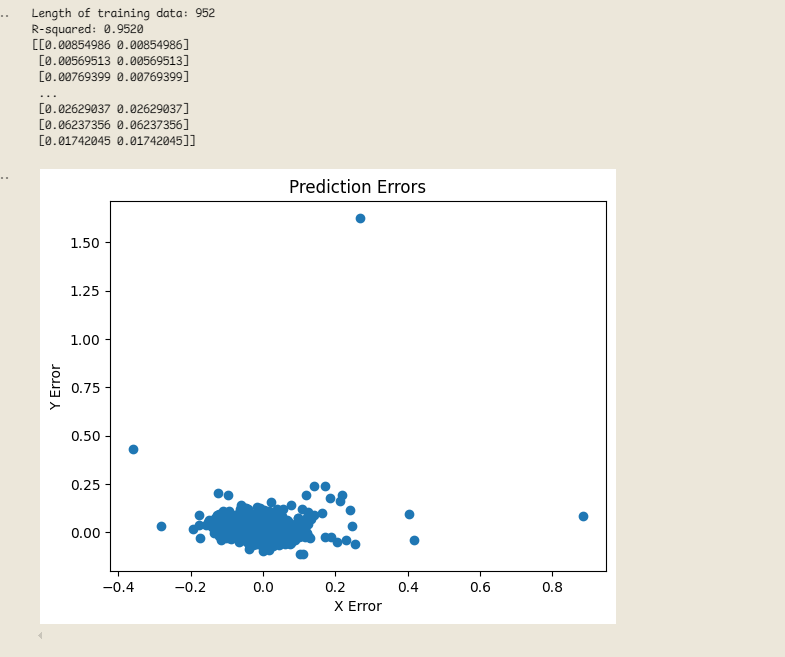

In [118]:
from sklearn.ensemble import RandomForestRegressor

from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

rf_model = RandomForestRegressor(random_state=seed, n_jobs=njobs)

param_space = {
    'n_estimators': Integer(50, 750),          # Number of trees
    'max_depth': Integer(5, 50),               # Depth of each tree
    'min_samples_split': Integer(2, 10),       # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),        # Minimum samples at a leaf node
    'max_features': Real(0.1, 1.0, prior='uniform')    # Features to consider
}

rf_opt = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    n_iter=50,                 # Number of iterations for optimization
    cv=kf,                     # K-Fold Cross Validation
    scoring='r2',              # Metric to optimize
    random_state=seed,
    n_jobs=njobs                  # Use all available cores
)

In [119]:
# if file exists
if os.path.isfile('output/rf_bayes_opt.pkl'):
  # load
  with open('output/rf_bayes_opt.pkl', 'rb') as f:
    rf_opt = pickle.load(f)
else:
  rf_opt.fit(X_train_tuning, y_train_tuning)

In [120]:
print("Best Parameters:", rf_opt.best_params_)
print("Best Validation Score:", rf_opt.best_score_)

# Evaluate on the validation set
val_score = rf_opt.best_estimator_.score(X_test, y_test)
print("Test Set Score:", val_score)

# Evaluate on the test set
test_score = rf_opt.best_estimator_.score(X_custom_eval, y_custom_eval)
print("Evaluation Set Score:", test_score)
if not os.path.isfile('output/rf_bayes_opt.pkl'):    
    with open('output/rf_bayes_opt.pkl', 'wb') as f:
        pickle.dump(rf_opt, f)

Best Parameters: OrderedDict({'max_depth': 50, 'max_features': 0.665508869053305, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
Best Validation Score: 0.9110527444522384
Test Set Score: 0.9686333521162195
Evaluation Set Score: 0.5515700097474805


`Best Parameters: OrderedDict({'max_depth': 27, 'max_features': 0.7230302205943789, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750})
Best Validation Score: 0.9955409082396779
Test Set Score: 0.9896417178652428
Evaluation Set Score: 0.8879499719441363`

In [121]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=seed, n_jobs=njobs)

# Define the hyperparameter search space
param_space = {
    'n_estimators': Integer(50, 750),             # Number of boosting rounds
    'max_depth': Integer(3, 20),                  # Maximum depth of trees
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Learning rate
    'min_child_weight': Integer(1, 10),           # Minimum sum of instance weight
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Subsample ratio for columns
    'gamma': Real(0.0, 5.0, prior='uniform')      # Minimum loss reduction
}

# Initialize BayesSearchCV
xgb_opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

In [122]:
if os.path.isfile('output/xgb_bayes_opt.pkl'):
  # load
  with open('output/xgb_bayes_opt.pkl', 'rb') as f:
    xgb_opt = pickle.load(f)
else:
  xgb_opt.fit(X_train_tuning, y_train_tuning)

In [123]:
# Print best parameters and scores
print("Best Parameters:", xgb_opt.best_params_)
print("Best Validation Score:", xgb_opt.best_score_)

# Evaluate on the test set
test_score = r2_score(y_test, xgb_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, xgb_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/xgb_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/xgb_bayes_opt.pkl", "wb") as file:
        pickle.dump(xgb_opt, file)
        print("Optimization results saved to 'xgb_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 635, 'subsample': 1.0})
Best Validation Score: 0.9201242327690125
Test Set Score: 0.9774792194366455
Evaluation Set Score (Custom Data): 0.4899672567844391


In [124]:
# Initialize k-NN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=njobs)

# Define the hyperparameter search space
param_space = {
    'n_neighbors': Integer(2, 75),               # Number of neighbors
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': Integer(1, 3)                           # Power parameter for Minkowski (if metric='minkowski')
}

# Initialize BayesSearchCV
knn_opt = BayesSearchCV(
    estimator=knn_model,
    search_spaces=param_space,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

In [125]:
if os.path.isfile('output/knn_bayes_opt.pkl'):
  # load
  with open('output/knn_bayes_opt.pkl', 'rb') as f:
    knn_opt = pickle.load(f)
else:
  knn_opt.fit(X_train_tuning, y_train_tuning)

In [126]:
# Print best parameters and scores
print("Best Parameters:", knn_opt.best_params_)
print("Best Validation Score:", knn_opt.best_score_)

# Evaluate on the test set
test_score = r2_score(y_test, knn_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, knn_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/knn_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/knn_bayes_opt.pkl", "wb") as file:
        pickle.dump(knn_opt, file)
        print("Optimization results saved to 'knn_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'metric': 'minkowski', 'n_neighbors': 6, 'p': 2, 'weights': 'distance'})
Best Validation Score: 0.8715603631853083
Test Set Score: 0.9227070371592994
Evaluation Set Score (Custom Data): 0.42226015620957313


In [127]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define pipeline for scaling (Lasso requires feature scaling)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', Lasso(max_iter=10000, random_state=seed))  # Lasso regression
])

# Define hyperparameter search space
param_space = {
    'lasso__alpha': Real(1e-4, 1.0, prior='log-uniform')  # Regularization strength
}

lasso_opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=50,
    cv=kf,
    scoring='r2',
    random_state=42,
    n_jobs=njobs
)

In [128]:
if os.path.isfile('output/lasso_bayes_opt.pkl'):
    # load
    with open('output/lasso_bayes_opt.pkl', 'rb') as f:
        lasso_opt = pickle.load(f)
else:   
    lasso_opt.fit(X_train_tuning, y_train_tuning)
        

In [129]:
print("Best Parameters:", lasso_opt.best_params_)
print("Best Validation Score:", lasso_opt.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test, lasso_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, lasso_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/lasso_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/lasso_bayes_opt.pkl", "wb") as file:
        pickle.dump(lasso_opt, file)
        print("Optimization results saved to 'lasso_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'lasso__alpha': 0.0001})
Best Validation Score: 0.9904060420267505
Test Set Score: 0.9877321088787052
Evaluation Set Score (Custom Data): 0.3401620205513514


### Next is the representation of a "Schemkes model" that serves as a baseline for the task.
#### It returns an interpolation of two points to predict PINKY_MCP namely WRIST and PINKY_PIP
Let's calculate that!

In [130]:
from sklearn.base import BaseEstimator, RegressorMixin

class SchemkesInterpolationModel(BaseEstimator, RegressorMixin):
    def __init__(self, train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC'):
        """
        Initialize the model with train and target column configurations.

        Parameters:
        - train_columns: List of column prefixes for the training features (default: ['WRIST', 'INDEX_FINGER_MCP'])
        - target_column: Column prefix for the target (default: 'THUMB_CMC')
        """
        self.train_columns = train_columns
        self.target_column = target_column
        self.vertical_ratio = None
        self.horizontal_ratio = None

    def fit(self, X, y):
        """
        Fit the model to compute the vertical and horizontal ratios.

        Parameters:
        - X: DataFrame with columns ['WRIST_x', 'WRIST_y', 'INDEX_FINGER_MCP_x', 'INDEX_FINGER_MCP_y']
        - y: DataFrame with columns ['THUMB_CMC_x', 'THUMB_CMC_y']
        """
        # Extract feature and target columns based on the prefixes
        wrist_x, wrist_y = f"{self.train_columns[0]}_x", f"{self.train_columns[0]}_y"
        index_x, index_y = f"{self.train_columns[1]}_x", f"{self.train_columns[1]}_y"
        thumb_x, thumb_y = f"{self.target_column}_x", f"{self.target_column}_y"

        # Calculate distances
        wrist_to_index_vertical = np.abs(X[wrist_y] - X[index_y])
        wrist_to_index_horizontal = np.abs(X[wrist_x] - X[index_x])

        wrist_to_thumb_vertical = np.abs(X[wrist_y] - y[thumb_y])
        wrist_to_thumb_horizontal = np.abs(X[wrist_x] - y[thumb_x])

        # Compute ratios
        if np.mean(wrist_to_index_vertical) == 0:
            self.vertical_ratio = 0
        else:
            self.vertical_ratio = np.mean(wrist_to_thumb_vertical) / np.mean(wrist_to_index_vertical)
        
        if np.mean(wrist_to_index_horizontal) == 0:
            self.horizontal_ratio = 0
        else:
            self.horizontal_ratio = np.mean(wrist_to_thumb_horizontal) / np.mean(wrist_to_index_horizontal)
        return self

    def predict(self, X):
        """
        Predict THUMB_CMC_x and THUMB_CMC_y coordinates.

        Parameters:
        - X: DataFrame with columns ['WRIST_x', 'WRIST_y', 'INDEX_FINGER_MCP_x', 'INDEX_FINGER_MCP_y']

        Returns:
        - np.array of shape (n_samples, 2) with predicted THUMB_CMC_x and THUMB_CMC_y.
        """
        if self.vertical_ratio is None or self.horizontal_ratio is None:
            raise ValueError("The model must be fitted before predicting.")

        # Extract feature columns based on the prefixes
        wrist_x, wrist_y = f"{self.train_columns[0]}_x", f"{self.train_columns[0]}_y"
        index_x, index_y = f"{self.train_columns[1]}_x", f"{self.train_columns[1]}_y"

        # Compute predictions
        predictions = pd.DataFrame(columns=[f"{self.target_column}_x", f"{self.target_column}_y"])
        predictions[f"{self.target_column}_x"] = (1 - self.horizontal_ratio) * X[wrist_x] + self.horizontal_ratio * X[index_x]
        predictions[f"{self.target_column}_y"] = (1 - self.vertical_ratio) * X[wrist_y] + self.vertical_ratio * X[index_y]


        return predictions.to_numpy()

In [131]:
schemkes_model = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model.fit(X_train, y_train)

SchemkesInterpolationModel()

In [132]:
# Schemkes on test set
schemkes_predictions = schemkes_model.predict(X_test)
schemkes_r2 = r2_score(y_test, schemkes_predictions)
print("Schemkes R-squared on Test Set:", schemkes_r2)

# Schemkes on custom evaluation set
schemkes_custom_predictions = schemkes_model.predict(X_custom_eval)
schemkes_custom_r2 = r2_score(y_custom_eval, schemkes_custom_predictions)
print("Schemkes R-squared on Custom Evaluation Set:", schemkes_custom_r2)

# Try schemkes model that uses middle finger mcp instead of index finger mcp
schemkes_model_middle = SchemkesInterpolationModel(train_columns=['WRIST', 'MIDDLE_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_middle.fit(X_train, y_train)

# Schemkes middle on test set
schemkes_predictions_middle = schemkes_model_middle.predict(X_test)
schemkes_r2_middle = r2_score(y_test, schemkes_predictions_middle)
print("Schemkes R-squared on Test Set (Middle Finger MCP):", schemkes_r2_middle)

# Schemkes middle on custom evaluation set
schemkes_custom_predictions_middle = schemkes_model_middle.predict(X_custom_eval)
schemkes_custom_r2_middle = r2_score(y_custom_eval, schemkes_custom_predictions_middle)
print("Schemkes R-squared on Custom Evaluation Set (Middle Finger MCP):", schemkes_custom_r2_middle)

# Try schemkes model that uses wrist and pinky mcp
schemkes_model_pinky = SchemkesInterpolationModel(train_columns=['WRIST', 'PINKY_MCP'], target_column='THUMB_CMC')
schemkes_model_pinky.fit(X_train, y_train)

# Schemkes pinky on test set
schemkes_predictions_pinky = schemkes_model_pinky.predict(X_test)
schemkes_r2_pinky = r2_score(y_test, schemkes_predictions_pinky)
print("Schemkes R-squared on Test Set (Pinky MCP):", schemkes_r2_pinky)

# Schemkes pinky on custom evaluation set
schemkes_custom_predictions_pinky = schemkes_model_pinky.predict(X_custom_eval)
schemkes_custom_r2_pinky = r2_score(y_custom_eval, schemkes_custom_predictions_pinky)
print("Schemkes R-squared on Custom Evaluation Set (Pinky MCP):", schemkes_custom_r2_pinky)

# Try schemkes model that uses wrist and thumb mcp
schemkes_model_thumb = SchemkesInterpolationModel(train_columns=['WRIST', 'THUMB_MCP'], target_column='THUMB_CMC')
schemkes_model_thumb.fit(X_train, y_train)

# Schemkes thumb on test set
schemkes_predictions_thumb = schemkes_model_thumb.predict(X_test)
schemkes_r2_thumb = r2_score(y_test, schemkes_predictions_thumb)
print("Schemkes R-squared on Test Set (Thumb MCP):", schemkes_r2_thumb)

# Schemkes thumb on custom evaluation set
schemkes_custom_predictions_thumb = schemkes_model_thumb.predict(X_custom_eval)
schemkes_custom_r2_thumb = r2_score(y_custom_eval, schemkes_custom_predictions_thumb)
print("Schemkes R-squared on Custom Evaluation Set (Thumb MCP):", schemkes_custom_r2_thumb)

# Try schemkes model that uses wrist and ring finger mcp
schemkes_model_ring = SchemkesInterpolationModel(train_columns=['WRIST', 'RING_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_ring.fit(X_train, y_train)

# Schemkes ring on test set
schemkes_predictions_ring = schemkes_model_ring.predict(X_test)
schemkes_r2_ring = r2_score(y_test, schemkes_predictions_ring)
print("Schemkes R-squared on Test Set (Ring MCP):", schemkes_r2_ring)

# Schemkes ring on custom evaluation set
schemkes_custom_predictions_ring = schemkes_model_ring.predict(X_custom_eval)
schemkes_custom_r2_ring = r2_score(y_custom_eval, schemkes_custom_predictions_ring)
print("Schemkes R-squared on Custom Evaluation Set (Ring MCP):", schemkes_custom_r2_ring)




Schemkes R-squared on Test Set: 0.7620746934037265
Schemkes R-squared on Custom Evaluation Set: -0.10955749129830311
Schemkes R-squared on Test Set (Middle Finger MCP): -84.00505743055416
Schemkes R-squared on Custom Evaluation Set (Middle Finger MCP): -1.79258201649593
Schemkes R-squared on Test Set (Pinky MCP): -1.7672998954551253
Schemkes R-squared on Custom Evaluation Set (Pinky MCP): -7.072235632002313
Schemkes R-squared on Test Set (Thumb MCP): 0.9437010081745312
Schemkes R-squared on Custom Evaluation Set (Thumb MCP): 0.4544202113900491
Schemkes R-squared on Test Set (Ring MCP): -1.675467842610617
Schemkes R-squared on Custom Evaluation Set (Ring MCP): -6.5667214647960455


### Pipeline

Get dataset -> make folds -> calculate for each model

In [133]:
def interleaving_subsample(df, sample_size):
    """
    Perform interleaving subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).

    Returns:
        pd.DataFrame: Interleaved subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    # Calculate the interleaving step
    step = len(df) / sample_size

    # Select rows based on interleaved indices
    indices = (np.arange(sample_size) * step).astype(int)
    return df.iloc[indices]

def first_n_subsample(df, sample_size):
    """
    Perform first-n subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).

    Returns:
        pd.DataFrame: First-n subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    return df.iloc[:sample_size]

def random_subsample(df, sample_size, random_state=42):
    """
    Perform random subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Random subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    return df.sample(sample_size, random_state=random_state)

def calculate_euclidean_distances(set1, set2):
    """
    Calculate the Euclidean distance for each row between two sets of coordinates.

    Parameters:
        set1 (pd.DataFrame or np.ndarray): First set of coordinates (n, 2).
        set2 (pd.DataFrame or np.ndarray): Second set of coordinates (n, 2).

    Returns:
        np.ndarray: A numpy array of shape (n, 1) containing the Euclidean distances.
    """
    # Convert to numpy arrays if inputs are DataFrames
    if isinstance(set1, pd.DataFrame):
        set1 = set1.values
    if isinstance(set2, pd.DataFrame):
        set2 = set2.values

    # Ensure the inputs have the correct shape
    if set1.shape != set2.shape or set1.shape[1] != 2:
        raise ValueError("Both sets must have the shape (n, 2).")

    # Calculate Euclidean distances
    distances = np.sqrt(np.sum((set1 - set2) ** 2, axis=1))
    return distances.reshape(-1, 1)

def evaluation_pipeline(X_train, y_train, X_test, y_test ,X_eval, y_eval, models, model_names, training_sizes, additional_test_sets=None, output_dir='output', subsample="interleave"):
    """
    Evaluates all models and saves the results.

    Parameters:
        normed_X_df (pd.DataFrame): Normalized feature DataFrame.
        normed_y_df (pd.DataFrame): Normalized target DataFrame.
        X_eval (pd.DataFrame): Evaluation feature DataFrame.
        y_eval (pd.DataFrame): Evaluation target DataFrame.
        models (list): List of models to evaluate.
        model_names (list): List of model names.
        model_params (list): List of model parameters.
        additional_test_sets (dict): Dictionary of additional test sets. {"name": (X, y)}
        output_dir (str): Directory to save the results.
    """



    subsampling_methods = {
        "interleave": interleaving_subsample,
        "first_n": first_n_subsample,
        "random": random_subsample
    }

    total_results = {}
    # For every model add a dictionary 
    for model_name in model_names:
        total_results[model_name] = {
            'R2': [],
            'Test_Error': [],
            'Eval_Error': []
        }
        if additional_test_sets is not None:
            for test_name, (additional_test_X, additional_test_y) in additional_test_sets.items():
                total_results[model_name][f'{test_name}_Error'] = []

    training_sizes_copy = training_sizes.copy()
    # Append len(X_train) to the copy if not already 
    if len(X_train) not in training_sizes_copy:
        training_sizes_copy.append(len(X_train))
    # Sort
    training_sizes_copy.sort()

    for i in tqdm(range(len(training_sizes_copy)), desc="Iterations"):
        current_size = training_sizes_copy[i]
        if current_size <= 0 or current_size > len(X_train):
            break
        # print("Iteration:", i, "Training size:", int(current_size))
        X_subsampled = subsampling_methods[subsample](X_train, int(current_size))
        # Set the same rows for y
        y_subsampled = y_train.loc[X_subsampled.index]

        # Calculate the results for all models
        for m_index in tqdm(range(len(models)), desc="Models", leave=False):
            model_name = model_names[m_index]
            model = models[m_index]

            # Create dir for model_name if not exists
            if not os.path.exists(f'{output_dir}/{model_name}'):
                os.makedirs(f'{output_dir}/{model_name}')

            # Fit the model
            model.fit(X_subsampled, y_subsampled)

            # Pickle model
            with open(f'{output_dir}/{model_name}/{model_name}_{subsample}_{int(current_size)}.pkl', 'wb') as f:
                pickle.dump(model, f)

            # Calculate R2 score
            r2 = model.score(X_test, y_test)
            total_results[model_name]['R2'].append(r2)

            # Calculate the test error
            test_pred = model.predict(X_test)
            test_error = np.mean(calculate_euclidean_distances(y_test, test_pred))
            total_results[model_name]['Test_Error'].append(test_error)
            
            # Calculate the evaluation error
            eval_error = np.mean(calculate_euclidean_distances(y_eval, model.predict(X_eval)))
            total_results[model_name]['Eval_Error'].append(eval_error)
            if additional_test_sets is not None:
                # For additional test sets
                for test_name, (additional_test_X, additional_test_y) in additional_test_sets.items():
                    additional_test_error = np.mean(calculate_euclidean_distances(additional_test_y, model.predict(additional_test_X)))
                    total_results[model_name][f'{test_name}_Error'].append(additional_test_error)
                
    return total_results

In [134]:
schemkes_model = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')

tuned_models = [
    schemkes_model,
    rf_opt.best_estimator_,
    xgb_opt.best_estimator_,
    knn_opt.best_estimator_,
    lasso_opt.best_estimator_,
]

tuned_models_names = [
    'Schemkes',
    'RandomForest',
    'XGBoost',
    'KNN',
    'Lasso'
]

sizes = [int(1.33**(0.8*x)) for x in range(20, 45)] + [len(X_train)]
sizes.sort()

total_results = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes , additional_test_sets=additional_tests, output_dir='output')


Iterations: 100%|██████████| 26/26 [13:08<00:00, 30.31s/it] 


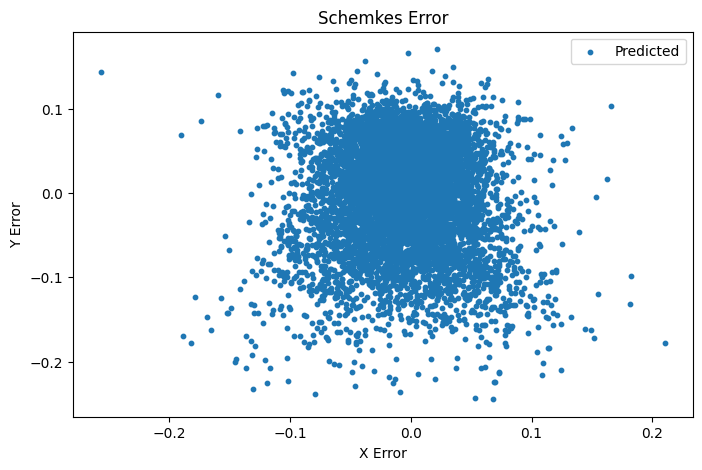

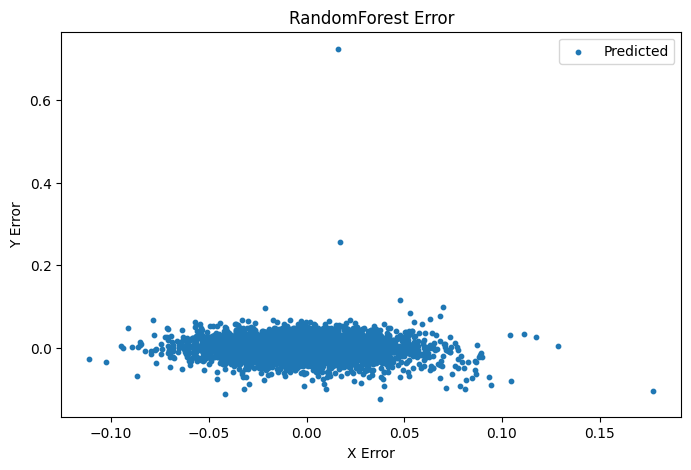

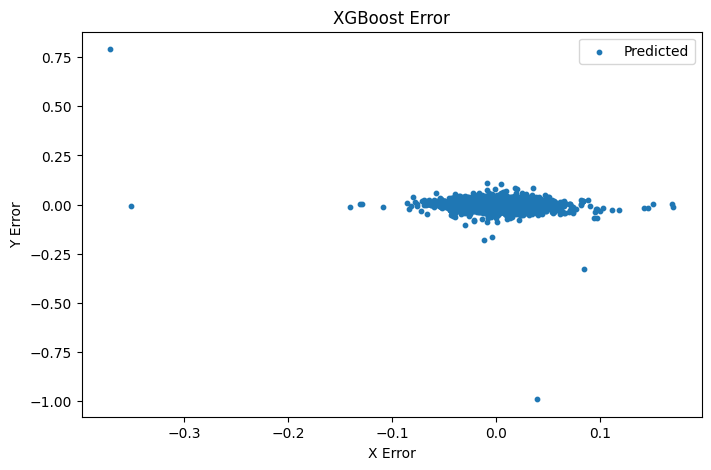

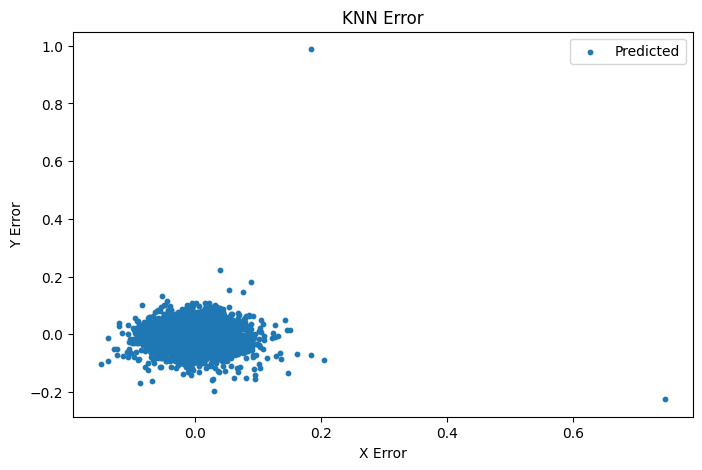

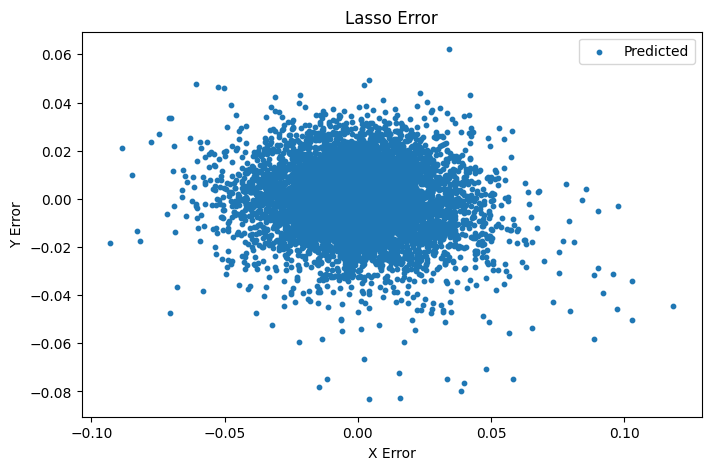

In [135]:
for i in range(len(tuned_models)):
    plt.figure(figsize=(8, 5))
    plt.scatter(tuned_models[i].predict(X_test)[:, 0] - y_test.to_numpy()[:, 0], tuned_models[i].predict(X_test)[:, 1] - y_test.to_numpy()[:, 1], label='Predicted', s=10)
    # plt.scatter(model.predict(X_custom_eval)[:, 0] - y_custom_eval[:, 0], model.predict(X_custom_eval)[:, 1] - y_custom_eval[:, 1], label='Evaluation', s=10)
    plt.xlabel('X Error')
    plt.ylabel('Y Error')
    plt.title(f'{tuned_models_names[i]} Error')
    plt.legend()   
    plt.show()
    


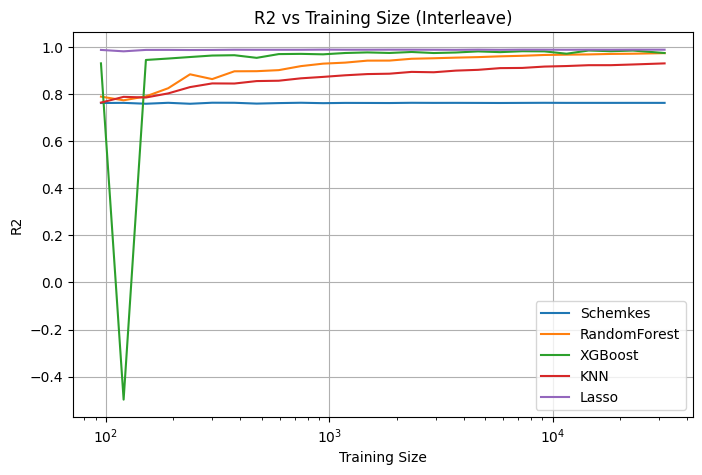

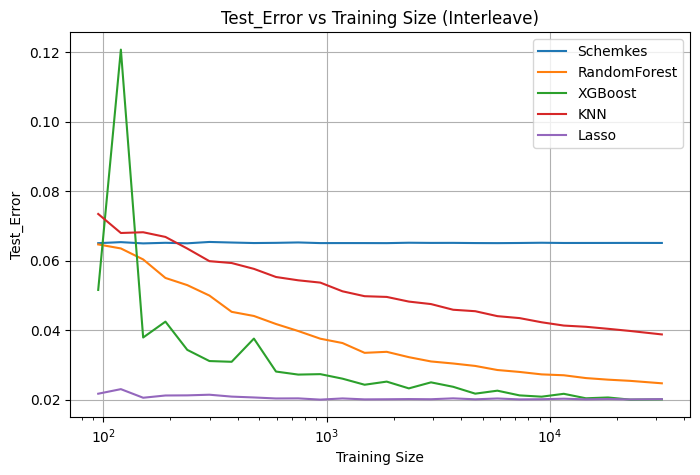

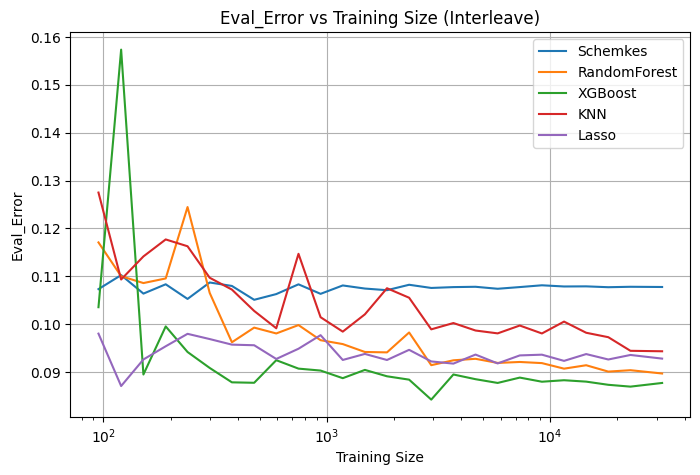

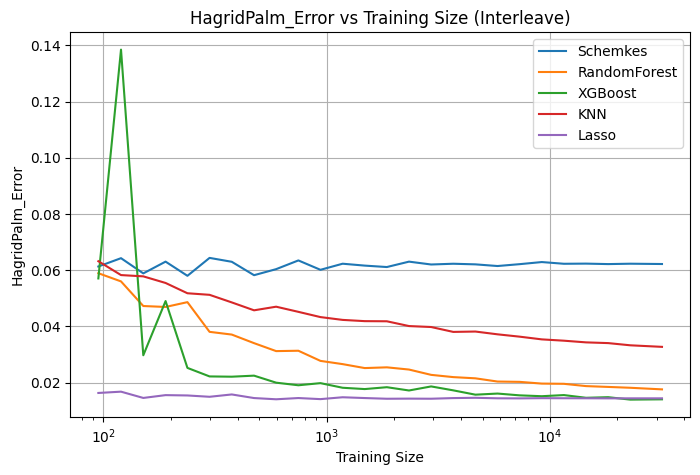

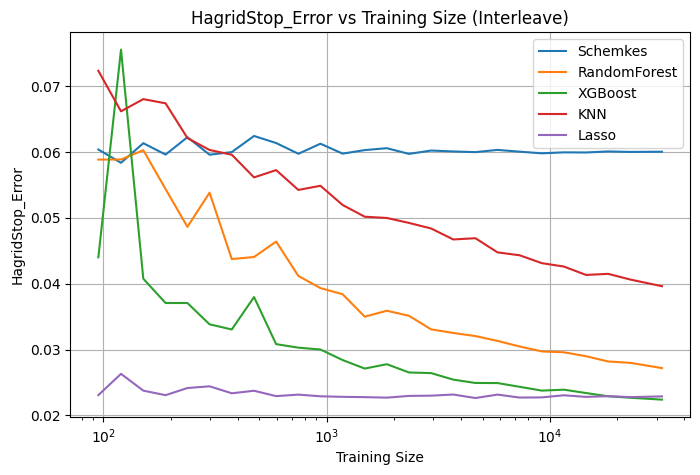

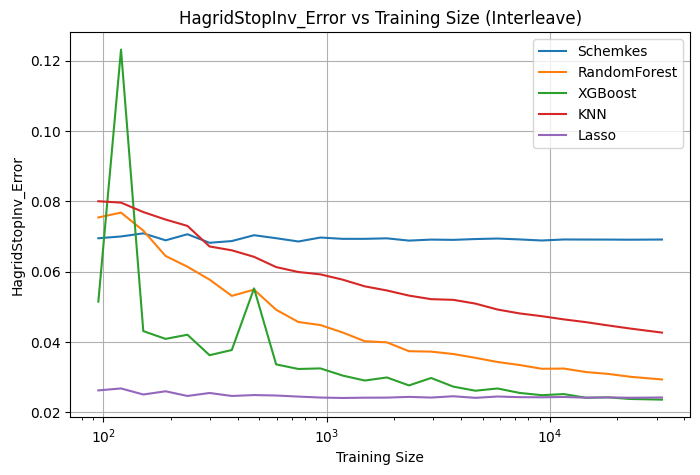

In [136]:
data = total_results
# As many as the length of metrics
x_values = sizes[:len(data['Schemkes']['R2'])]
metrics = list(data["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Interleave)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [137]:
total_results_first_n = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes, additional_test_sets=additional_tests, output_dir='output', subsample="first_n")

Iterations: 100%|██████████| 26/26 [06:22<00:00, 14.70s/it]


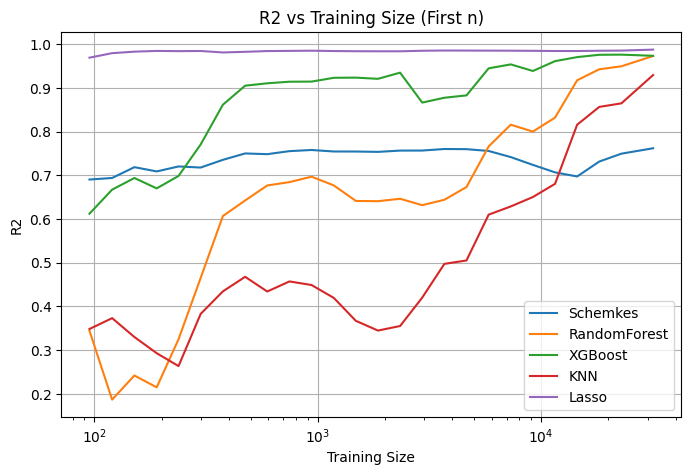

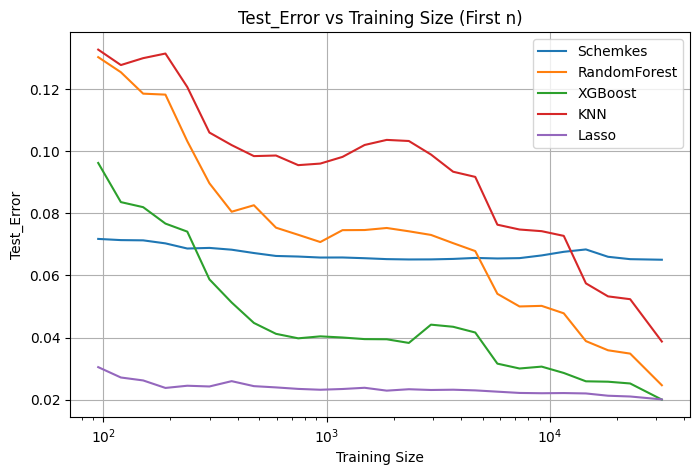

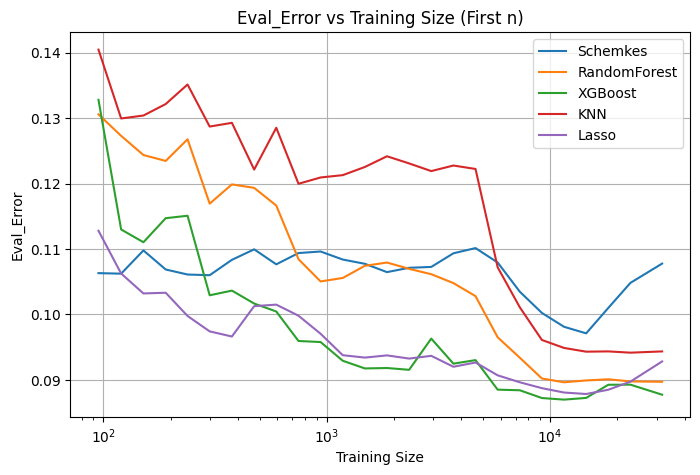

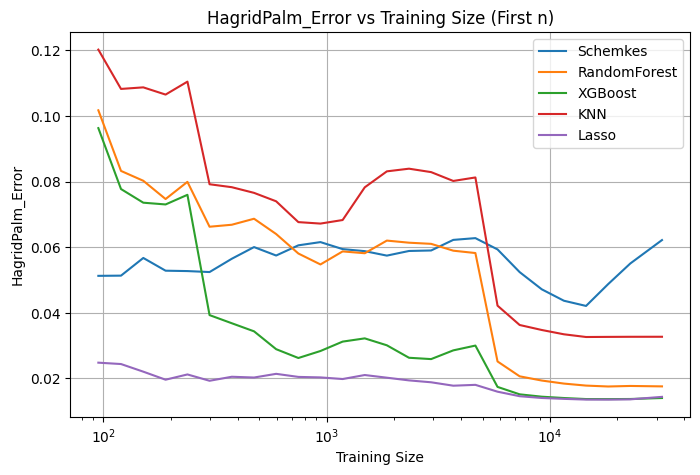

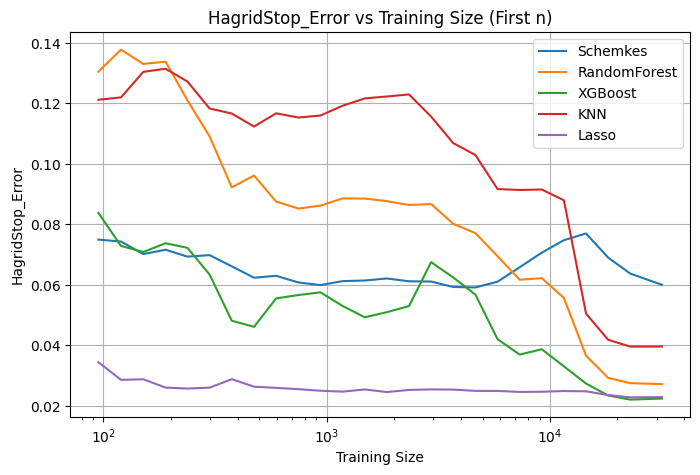

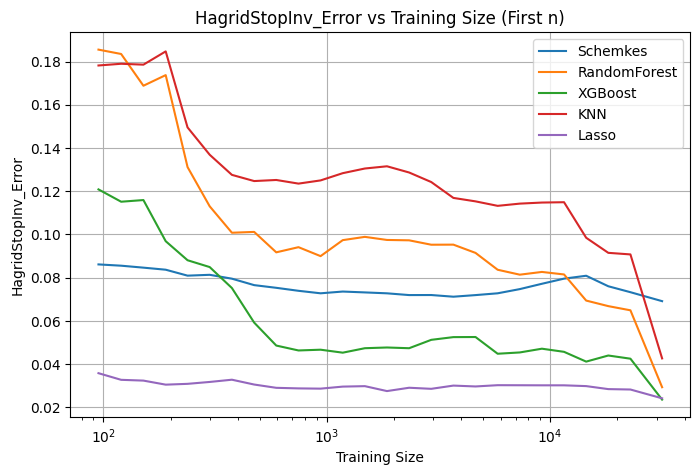

In [138]:
data_first_n = total_results_first_n

# As many as the length of metrics
x_values = sizes[:len(data_first_n['Schemkes']['R2'])]
metrics = list(data_first_n["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_first_n.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (First n)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [139]:
total_results_random = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes, additional_test_sets=additional_tests ,output_dir='output', subsample="random")

Iterations: 100%|██████████| 26/26 [06:43<00:00, 15.54s/it]


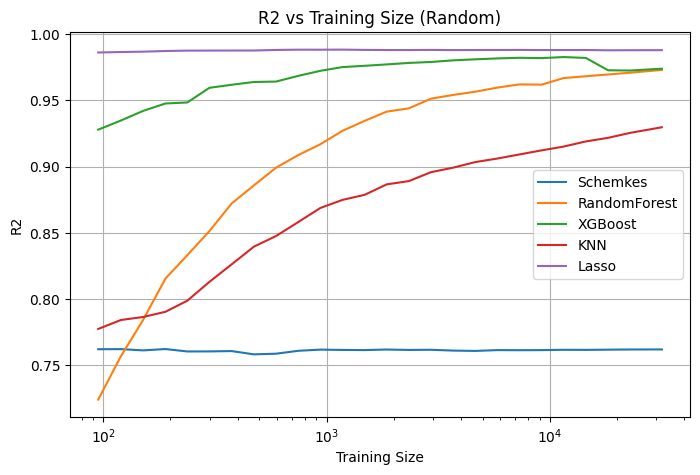

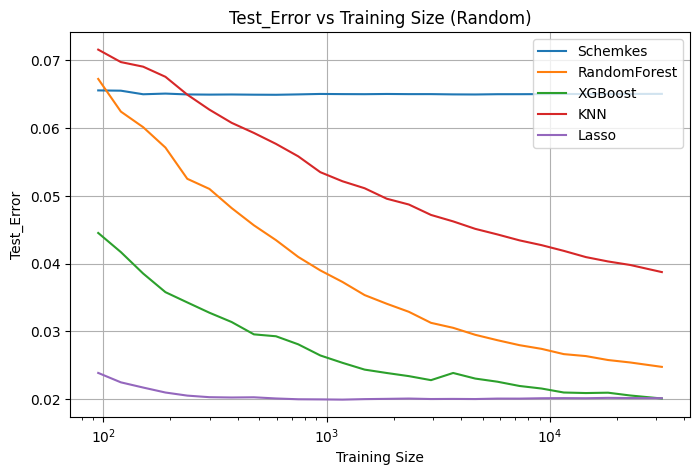

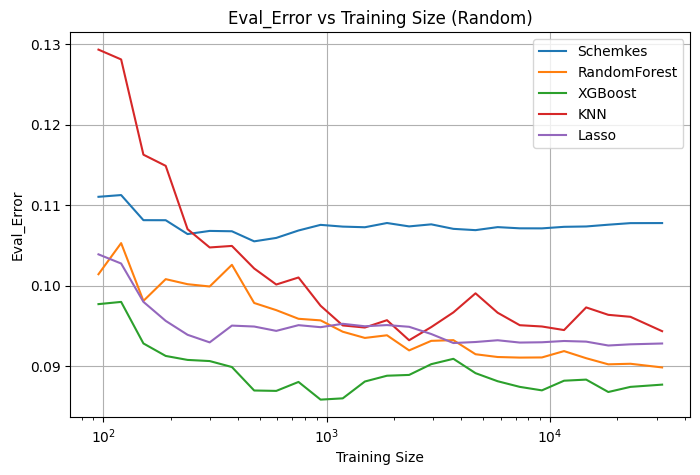

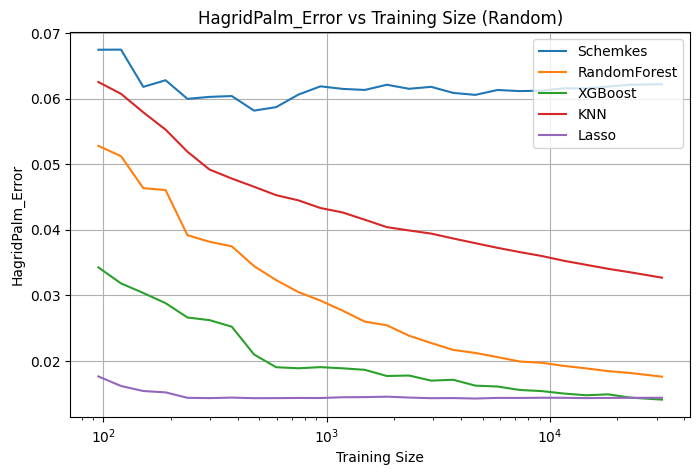

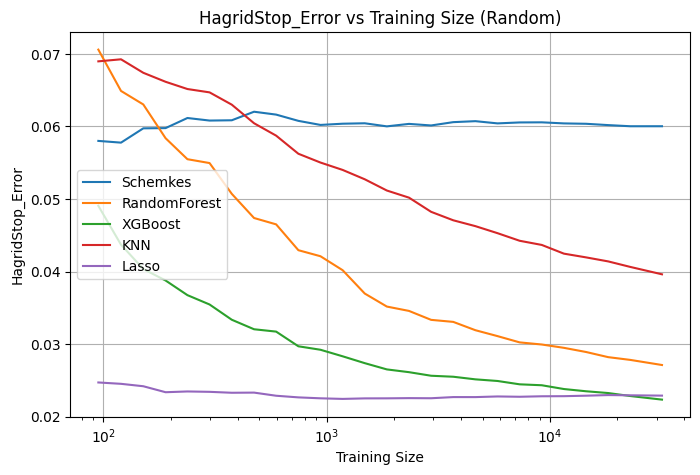

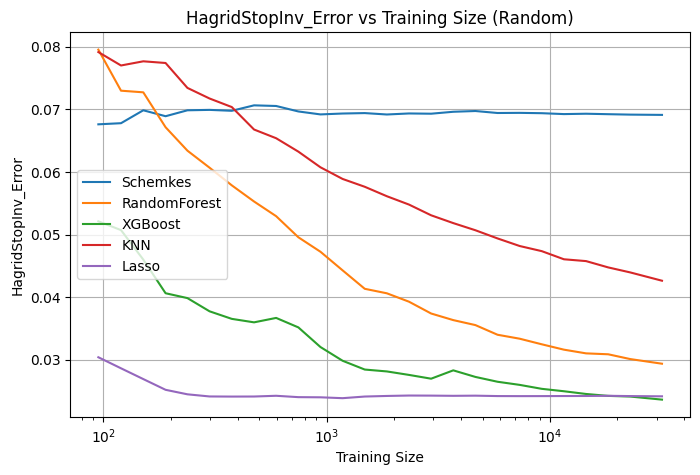

In [140]:
data_random = total_results_random

# As many as the length of metrics
x_values = sizes[:len(data_random['Schemkes']['R2'])]
metrics = list(data_random["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_random.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Random)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [141]:
print("FINISHED")

FINISHED


# INTERESTING RESULT FOR THE LASSO, LET'S EXAMINE!

[-0.03102343 -0.68851829]


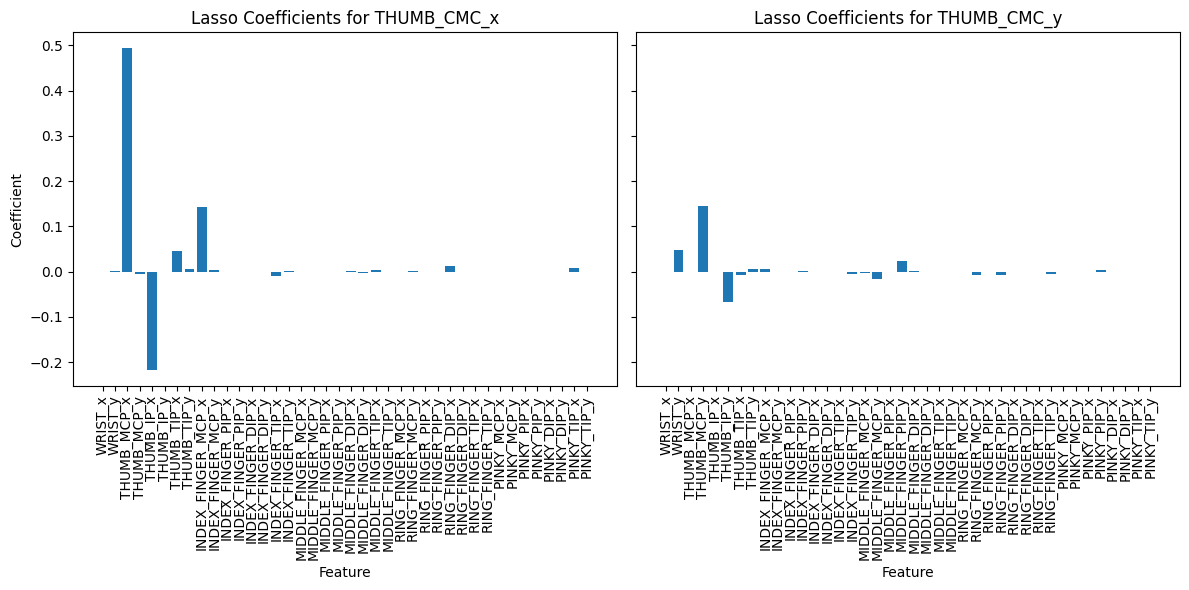

In [142]:
# Load 
best_lasso_model = None
with open("output/Lasso/Lasso_interleave_16447.pkl", "rb") as file:
    best_lasso_model = pickle.load(file)

print(best_lasso_model.named_steps['lasso'].intercept_)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot first bar chart
axes[0].bar(flattened_hand_keypoints_no_thumb_CMC, best_lasso_model.named_steps['lasso'].coef_[0])
axes[0].set_xticks(range(len(flattened_hand_keypoints_no_thumb_CMC)))
axes[0].set_xticklabels(flattened_hand_keypoints_no_thumb_CMC, rotation=90)
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Lasso Coefficients for THUMB_CMC_x')

# Plot second bar chart
axes[1].bar(flattened_hand_keypoints_no_thumb_CMC, best_lasso_model.named_steps['lasso'].coef_[1])
axes[1].set_xticks(range(len(flattened_hand_keypoints_no_thumb_CMC)))
axes[1].set_xticklabels(flattened_hand_keypoints_no_thumb_CMC, rotation=90)
axes[1].set_xlabel('Feature')
axes[1].set_title('Lasso Coefficients for THUMB_CMC_y')

# Adjust layout
plt.tight_layout()
plt.show()

# Let's attempt using our data to make it.

In [143]:
X_hypothenar = our_hands_total_normalized_df[flattened_keypoint_names + ['HYPOTHENAR_x', 'HYPOTHENAR_y']]
y_hypothenar = our_hands_total_normalized_df[['HYPOTHENAR_x', 'HYPOTHENAR_y']]
X_train_hypothenar, X_test_hypothenar, y_train_hypothenar, y_test_hypothenar = train_test_split(X_hypothenar, y_hypothenar, test_size=0.2, shuffle=False)
y_custom_eval_hypothenar = y_test_hypothenar
X_custom_eval_hypothenar = X_test_hypothenar

# Hyperparameter tune models
# Initialize Random Forest Regressor
rf_model_hypothernar = RandomForestRegressor(random_state=seed, n_jobs=njobs)
kf_hypo = KFold(n_splits=4, shuffle=True, random_state=seed)


# Define the hyperparameter search space
rf_param_space_hypothernar = {
    'n_estimators': Integer(50, 750),          # Number of trees
    'max_depth': Integer(5, 50),               # Depth of each tree
    'min_samples_split': Integer(2, 10),       # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),        # Minimum samples at a leaf node
    'max_features': Real(0.1, 1.0, prior='uniform')    # Features to consider
}

rf_opt_hypothenar = BayesSearchCV(
    estimator=rf_model_hypothernar,
    search_spaces=rf_param_space_hypothernar,
    n_iter=50,                 # Number of iterations for optimization
    cv=kf_hypo,                     # K-Fold Cross Validation
    scoring='r2',              # Metric to optimize
    random_state=seed,
    n_jobs=njobs                  # Use all available cores
)

if os.path.isfile('output_new/rf_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/rf_bayes_opt_hypothenar.pkl', 'rb') as f:
    rf_opt_hypothenar = pickle.load(f)
else:
  rf_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

print("Best Parameters:", rf_opt_hypothenar.best_params_)
print("Best Validation Score:", rf_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = rf_opt_hypothenar.best_estimator_.score(X_test_hypothenar, y_test_hypothenar)
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/rf_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/rf_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(rf_opt_hypothenar, file)
        print("Optimization results saved to 'rf_bayes_opt_hypothenar.pkl'.")

# Initialize XGBRegressor
xgb_model_hypothenar = XGBRegressor(random_state=seed, n_jobs=njobs)

# Define the hyperparameter search space

xgb_param_space_hypothenar = {
    'n_estimators': Integer(50, 750),             # Number of boosting rounds
    'max_depth': Integer(3, 20),                  # Maximum depth of trees
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Learning rate
    'min_child_weight': Integer(1, 10),           # Minimum sum of instance weight
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Subsample ratio for columns
    'gamma': Real(0.0, 5.0, prior='uniform')      # Minimum loss reduction
}

# Initialize BayesSearchCV
xgb_opt_hypothenar = BayesSearchCV(
    estimator=xgb_model_hypothenar,
    search_spaces=xgb_param_space_hypothenar,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf_hypo,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

if os.path.isfile('output_new/xgb_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/xgb_bayes_opt_hypothenar.pkl', 'rb') as f:
    xgb_opt_hypothenar = pickle.load(f)
else:
  xgb_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

# Print best parameters and scores
print("Best Parameters:", xgb_opt_hypothenar.best_params_)
print("Best Validation Score:", xgb_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, xgb_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/xgb_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/xgb_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(xgb_opt_hypothenar, file)
        print("Optimization results saved to 'xgb_bayes_opt_hypothenar.pkl'.")

# Initialize k-NN Regressor
knn_model_hypothenar = KNeighborsRegressor(n_jobs=njobs)

# Define the hyperparameter search space

knn_param_space_hypothenar = {
    'n_neighbors': Integer(2, 75),               # Number of neighbors
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': Integer(1, 3)                           # Power parameter for Minkowski (if metric='minkowski')
}

# Initialize BayesSearchCV
knn_opt_hypothenar = BayesSearchCV(
    estimator=knn_model_hypothenar,
    search_spaces=knn_param_space_hypothenar,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf_hypo,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

if os.path.isfile('output_new/knn_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/knn_bayes_opt_hypothenar.pkl', 'rb') as f:
    knn_opt_hypothenar = pickle.load(f)
else:
  knn_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

# Print best parameters and scores
print("Best Parameters:", knn_opt_hypothenar.best_params_)
print("Best Validation Score:", knn_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, knn_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/knn_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/knn_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(knn_opt_hypothenar, file)
        print("Optimization results saved to 'knn_bayes_opt_hypothenar.pkl'.")


# Initialize Lasso
lasso_model_hypothenar = Lasso(max_iter=10000, random_state=seed)

# Define pipeline for scaling (Lasso requires feature scaling)
pipeline_hypothenar = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', lasso_model_hypothenar)  # Lasso regression
])

# Define hyperparameter search space
param_space_hypothenar = {
    'lasso__alpha': Real(1e-4, 1.0, prior='log-uniform')  # Regularization strength
}

lasso_opt_hypothenar = BayesSearchCV(
    estimator=pipeline_hypothenar,
    search_spaces=param_space_hypothenar,
    n_iter=50,
    cv=kf_hypo,
    scoring='r2',
    random_state=42,
    n_jobs=njobs
)

if os.path.isfile('output_new/lasso_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/lasso_bayes_opt_hypothenar.pkl', 'rb') as f:
    lasso_opt_hypothenar = pickle.load(f)
else:
  lasso_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

print("Best Parameters:", lasso_opt_hypothenar.best_params_)
print("Best Validation Score:", lasso_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, lasso_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/lasso_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/lasso_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(lasso_opt_hypothenar, file)
        print("Optimization results saved to 'lasso_bayes_opt_hypothenar.pkl'.")


Best Parameters: OrderedDict({'max_depth': 50, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750})
Best Validation Score: 0.9052945031698838
Test Set Score: 0.9304568376720279
Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 17, 'min_child_weight': 1, 'n_estimators': 661, 'subsample': 0.5565124489551536})
Best Validation Score: 0.9844405353069305
Test Set Score: 0.9927172660827637
Best Parameters: OrderedDict({'metric': 'minkowski', 'n_neighbors': 5, 'p': 3, 'weights': 'distance'})
Best Validation Score: 0.844832976073939
Test Set Score: 0.8344827149356658
Best Parameters: OrderedDict({'lasso__alpha': 0.0001})
Best Validation Score: 0.9999990150043543
Test Set Score: 0.9999991504597323


In [144]:
schemkes_model_hypothenar = SchemkesInterpolationModel(train_columns=['WRIST', 'PINKY_MCP'], target_column='HYPOTHENAR')

tuned_models_hypothenar = [
    schemkes_model_hypothenar,
    rf_opt_hypothenar.best_estimator_,
    xgb_opt_hypothenar.best_estimator_,
    knn_opt_hypothenar.best_estimator_,
    lasso_opt_hypothenar.best_estimator_,
]

sizes_hypo = [p*len(X_train_hypothenar) for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]


total_results_hypo = evaluation_pipeline(X_train=X_train_hypothenar, y_train=y_train_hypothenar,
                                    X_test=X_test_hypothenar, y_test=y_test_hypothenar,
                                    X_eval=X_custom_eval_hypothenar, y_eval=y_custom_eval_hypothenar,
                                    models=tuned_models_hypothenar, model_names=tuned_models_names,
                                    training_sizes=sizes_hypo, additional_test_sets=None, output_dir='output_new', subsample='random')

Iterations: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


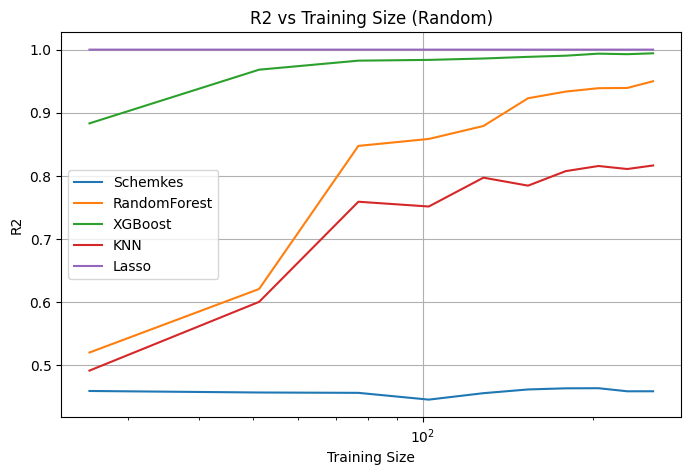

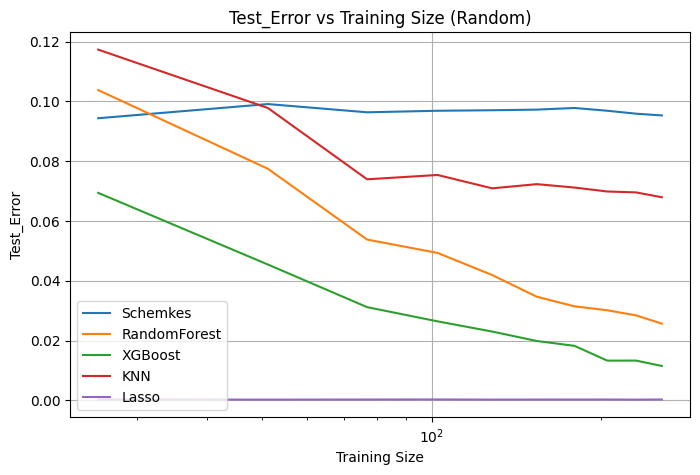

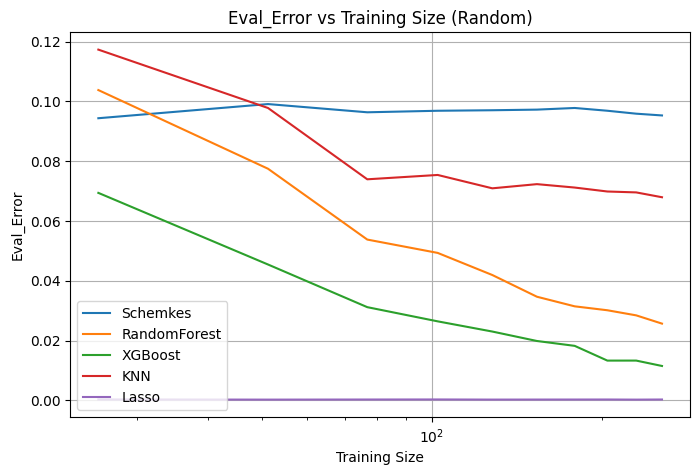

In [145]:
# Plot the results

data_hypo = total_results_hypo

# As many as the length of metrics
x_values = sizes_hypo[:len(data_hypo['Schemkes']['R2'])]
metrics = list(data_hypo["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_hypo.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Random)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [146]:
def get_denormalized_predictions(original_df, predictions, target_keypoints_columns, hand_keypoints = None):
    """
    Denormalizes the predicted keypoints.

    Parameters:
        predictions (np.ndarray): Predicted keypoints.
        hand_keypoints (pd.DataFrame): Normalized hand keypoints.
        target_keypoints (list): Target keypoint names.

    Returns:
        pd.DataFrame: Denormalized predictions.
    """
    image_space_with_predictions_df = original_df.copy()
    image_space_with_predictions_df[target_keypoints_columns] = predictions
    if hand_keypoints is None:
        # Automatically extract hand keypoints from the original DataFrame
        hand_keypoints = process_strings(list(image_space_with_predictions_df.columns))
    image_space_with_predictions_df = transform_to_image_space(image_space_with_predictions_df, hand_keypoints)
    
    return image_space_with_predictions_df

In [147]:
schemkes_model_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)
# xgb_opt_hypothenar.best_estimator_.fit(X_train_hypothenar, y_train_hypothenar)
temp_df = our_hands_total_normalized_df.copy()

schemkes_hypothenar_predictions = schemkes_model_hypothenar.predict(X_hypothenar)
# xgb_opt_hypotenar_predictions = xgb_opt_hypothenar.best_estimator_.predict(X_train_hypothenar)
# Get the same rows from temp_df as X_train_hypothenar
temp_df = temp_df.loc[X_hypothenar.index]
# Get the denormalized predictions
our_hands_total_with_hypothenar_predictions = get_denormalized_predictions(temp_df, 
                                                                          schemkes_hypothenar_predictions, 
                                                                          ['PRED_HYPOTHENAR_x', 'PRED_HYPOTHENAR_y'], 
                                                                          None)



71_IMG_4624.json


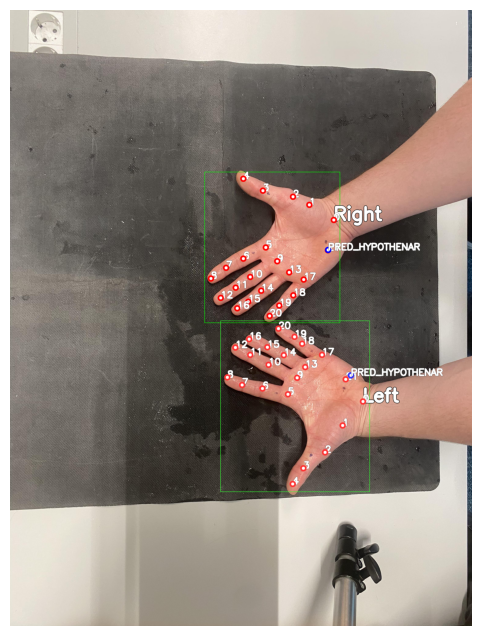

In [148]:
# Random filename for the output image
random_file_name = our_hands_total_with_hypothenar_predictions.iloc[random.randint(0, len(our_hands_total_with_hypothenar_predictions))]['FILE_NAME']
print(random_file_name)
attempt_to_draw_from_df(our_hands_total_with_hypothenar_predictions, 
                        random_file_name,
                        ['our_hands_dataset/FOLDER_FOR_DRAWING'],
                        list(hand_keypoints_names.values()) + ['HYPOTHENAR'],
                        ['PRED_HYPOTHENAR'], figsize=(8, 8))

In [149]:
# Plot lasso coefficients

best_lasso_hypothenar = lasso_opt_hypothenar.best_estimator_
lasso_opt_hypothenar.best_estimator_.fit(X_train_hypothenar, y_train_hypothenar)
flattened_hand_keypoints_hypothenar = [flkp for flkp in X_train_hypothenar.columns if flkp.endswith('_x') or flkp.endswith('_y')]
flattened_hand_keypoints_no_hypothenar = [flkp for flkp in flattened_hand_keypoints_hypothenar if 'HYPOTHENAR' not in flkp]

best_lasso_hypothenar.named_steps['lasso'].coef_.shape
X_train_hypothenar
# # Create subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# # Plot first bar chart
# axes[0].bar(flattened_hand_keypoints_no_hypothenar, best_lasso_hypothenar.named_steps['lasso'].coef_[0])
# axes[0].set_xticks(range(len(flattened_hand_keypoints_no_hypothenar)))
# axes[0].set_xticklabels(flattened_hand_keypoints_no_hypothenar, rotation=90)
# axes[0].set_xlabel('Feature')
# axes[0].set_ylabel('Coefficient')
# axes[0].set_title('Lasso Coefficients for HYPOTHENAR_x')

# # Plot second bar chart
# axes[1].bar(flattened_hand_keypoints_no_hypothenar, best_lasso_hypothenar.named_steps['lasso'].coef_[1])
# axes[1].set_xticks(range(len(flattened_hand_keypoints_no_hypothenar)))
# axes[1].set_xticklabels(flattened_hand_keypoints_no_hypothenar, rotation=90)
# axes[1].set_xlabel('Feature')
# axes[1].set_title('Lasso Coefficients for HYPOTHENAR_y')

# # Adjust layout
# plt.tight_layout()
# plt.show()


WRIST_x   WRIST_y  THUMB_CMC_x  THUMB_CMC_y  THUMB_MCP_x  THUMB_MCP_y  \
0    0.247366 -0.876958    -0.146587    -0.800537    -0.483089    -0.473159   
1   -0.356959 -0.851494    -0.036261    -0.762151     0.350305    -0.513692   
2    0.289825 -0.882653    -0.129466    -0.863536    -0.538188    -0.503547   
3   -0.339027 -0.888885     0.093454    -0.785272     0.543086    -0.419061   
4    0.233564 -0.895973    -0.112178    -0.757037    -0.563662    -0.401795   
..        ...       ...          ...          ...          ...          ...   
251 -0.222725 -0.887449     0.105217    -0.691535     0.458627    -0.391602   
252  0.032298 -0.935427    -0.348328    -0.783460    -0.726134    -0.464015   
253 -0.295926 -0.882564     0.008682    -0.616009     0.394641    -0.341556   
254  0.007752 -0.935708    -0.374632    -0.780049    -0.697755    -0.542138   
255 -0.337638 -0.862956     0.019582    -0.652058     0.393325    -0.412687   

     THUMB_IP_x  THUMB_IP_y  THUMB_TIP_x  THUMB_TIP_y  ...  PINKY_MCP_x  \
0     -0.713086   -0.203014    -0.935066     0.029004  ...     0.692854   
1      0.589497   -0.319036     0.902876    -0.128651  ...    -0.762487   
2     -0.686149   -0.180147    -0.923537     0.081135  ...     0.713181   
3      0.641900   -0.209745     0.914174     0.048177  ...    -0.792362   
4     -0.745641   -0.190380    -0.916334     0.083729  ...     0.684453   
..          ...         ...          ...          ...  ...          ...   
251    0.753922   -0.092189     0.924924     0.058537  ...    -0.722357   
252   -0.852808   -0.147845    -0.986234     0.147901  ...     0.587266   
253    0.643280   -0.060686     0.924178     0.092046  ...    -0.750897   
254   -0.845382   -0.184193    -0.948303     0.042086  ...     0.488871   
255    0.611053   -0.153121     0.915964    -0.042870  ...    -0.732379   

     PINKY_MCP_y  PINKY_PIP_x  PINKY_PIP_y  PINKY_DIP_x  PINKY_DIP_y  \
0      -0.000305     0.758322     0.212525     0.821117     0.438064   
1       0.084632    -0.814717     0.320026    -0.803406     0.503846   
2      -0.065121     0.755252     0.135500     0.865003     0.304384   
3      -0.008184    -0.850832     0.139481    -0.856095     0.319633   
4      -0.049033     0.792176     0.180972     0.812374     0.343390   
..           ...          ...          ...          ...          ...   
251    -0.019427    -0.780669     0.327100    -0.799254     0.536136   
252    -0.019625     0.675041     0.245886     0.721296     0.481171   
253     0.022358    -0.795231     0.359588    -0.811713     0.527593   
254    -0.124546     0.635166     0.156300     0.710216     0.402324   
255     0.049162    -0.767252     0.299125    -0.790987     0.484198   

     PINKY_TIP_x  PINKY_TIP_y  HYPOTHENAR_x  HYPOTHENAR_y  
0       0.806802     0.581034      0.530233     -0.724587  
1      -0.785775     0.648970     -0.662020     -0.671018  
2       0.858093     0.512672      0.589812     -0.692804  
3      -0.875195     0.548637     -0.597074     -0.668249  
4       0.876730     0.533431      0.529008     -0.728285  
..           ...          ...           ...           ...  
251    -0.832982     0.631516     -0.615076     -0.521202  
252     0.749211     0.692764      0.439731     -0.561269  
253    -0.838684     0.705035     -0.678712     -0.484097  
254     0.798488     0.550774      0.308523     -0.632646  
255    -0.807785     0.644439     -0.612971     -0.428252  

[256 rows x 44 columns]

Schemkes R-squared on Test Set: 0.7620746934037265
Schemkes R-squared on Custom Evaluation Set: -0.10955749129830311
60_IMG_4613.json


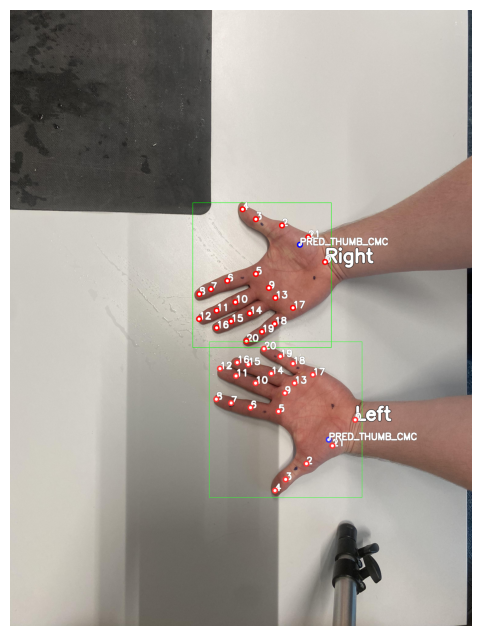

In [150]:
schemkes_model_normal = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_normal.fit(X_train, y_train)

# Schemkes on test set
schemkes_predictions = schemkes_model_normal.predict(X_test)
schemkes_r2 = r2_score(y_test, schemkes_predictions)

# Schemkes on custom evaluation set
schemkes_custom_predictions = schemkes_model_normal.predict(X_custom_eval)
schemkes_custom_r2 = r2_score(y_custom_eval, schemkes_custom_predictions)

print("Schemkes R-squared on Test Set:", schemkes_r2)
print("Schemkes R-squared on Custom Evaluation Set:", schemkes_custom_r2)

temp_df = our_hands_total_normalized_df.copy()
# Get the same rows from temp_df as X_custom_eval
temp_df = temp_df.loc[X_custom_eval.index]
# Get the denormalized predictions
our_hands_total_with_schemkes_predictions = get_denormalized_predictions(temp_df, 
                                                                          schemkes_custom_predictions, 
                                                                          ['PRED_THUMB_CMC_x', 'PRED_THUMB_CMC_y'], 
                                                                          None)

# Random filename for the output image
random_file_name = our_hands_total_with_schemkes_predictions.iloc[random.randint(0, len(our_hands_total_with_schemkes_predictions))]['FILE_NAME']
print(random_file_name)
attempt_to_draw_from_df(our_hands_total_with_schemkes_predictions, 
                        random_file_name,
                        ['our_hands_dataset/FOLDER_FOR_DRAWING'],
                        list(hand_keypoints_names.values()) + ['THUMB_CMC'],
                        ['PRED_THUMB_CMC'], figsize=(8, 8))

